In [1]:
using Comrade

In [2]:
using StableRNGs
rng = StableRNG(123)

StableRNGs.LehmerRNG(state=0x000000000000000000000000000000f7)

In [3]:
obs = load_ehtim_uvfits(joinpath(dirname(pathof(Comrade)), "..", "examples", "PolarizedExamples/polarized_gaussian_nogains_withdterms_withfr.uvfits"),
                        joinpath(dirname(pathof(Comrade)), "..", "examples", "PolarizedExamples/array.txt"))

Python Obsdata: <ehtim.obsdata.Obsdata object at 0x2dfd73d60>

In [4]:
obs = scan_average(obs)

[ Info: Before homogenizing we have 49 unique times
[ Info: After homogenizing we have 49 unique times


Python Obsdata: <ehtim.obsdata.Obsdata object at 0x2dfd26c80>

In [5]:
dvis = extract_coherency(obs)

EHTObservation{Float64,Comrade.EHTCoherencyDatum{Float64, CirBasis, CirBasis, StaticArraysCore.SMatrix{2, 2, ComplexF64, 4}, StaticArraysCore.SMatrix{2, 2, Float64, 4}}, ...}
  source: 17.761122472222223:-28.992189444444445
  mjd: 51544
  frequency: 2.3e11
  bandwidth: 1.0e9
  stations: [:AA, :AP, :AZ, :JC, :LM, :PV, :SM]
  nsamples: 315


In [6]:
function model(θ, metadata)
    (;c, f, p, angparams, dRx, dRy, dLx, dLy, lgp, gpp, lgr, gpr) = θ
    (; grid, cache, tcache, scancache, trackcache) = metadata
    # Construct the image model
    # produce Stokes images from parameters
    imgI = f*c
    # Converts from poincare sphere parameterization of polzarization to Stokes Parameters
    pimg = PoincareSphere2Map(imgI, p, angparams, grid)
    m = ContinuousImage(pimg, cache)

    # Now construct the basis transformation cache
    jT = jonesT(tcache)

    # Gain product parameters
    gP = exp.(lgp/2 .+ 1im.*gpp/2)
    Gp = jonesG(gP, gP, scancache)
    # Gain ratio
    gR = exp.(lgr/2 .+ 1im.*gpr/2)
    Gr = jonesG(gR, inv.(gR), trackcache)
    ##D-terms
    D = jonesD(complex.(dRx, dRy), complex.(dLx, dLy), trackcache)
    # sandwich all the jones matrices together
    J = Gp*Gr*D*jT
    # form the complete Jones or RIME model. We use tcache here
    # to set the reference basis of the model.
    return JonesModel(J, m, tcache)
end

model (generic function with 1 method)

In [7]:
fovx = μas2rad(50.0)
fovy = μas2rad(50.0)
nx = 5
ny = floor(Int, fovy/fovx*nx)
grid = imagepixels(fovx, fovy, nx, ny) # image grid
buffer = IntensityMap(zeros(nx, ny), grid) # buffer to store temporary image
pulse = BSplinePulse{3}() # pulse we will be using
cache = create_cache(NFFTAlg(dvis), buffer, pulse) # cache to define the NFFT transform

Comrade.NUFTCache{Comrade.ObservedNUFT{NFFTAlg{Float64, AbstractNFFTs.PrecomputeFlags, UInt32}, Matrix{Float64}}, NFFT.NFFTPlan{Float64, 2, 1}, Vector{ComplexF64}, BSplinePulse{3}, AxisKeys.KeyedArray{Float64, 2, NamedDims.NamedDimsArray{(:X, :Y), Float64, 2, Matrix{Float64}}, GriddedKeys{(:X, :Y), Tuple{LinRange{Float64, Int64}, LinRange{Float64, Int64}}, Nothing, Float64}}}(Comrade.ObservedNUFT{NFFTAlg{Float64, AbstractNFFTs.PrecomputeFlags, UInt32}, Matrix{Float64}}(NFFTAlg{Float64, AbstractNFFTs.PrecomputeFlags, UInt32}(1, 4, 2.0, :kaiser_bessel, AbstractNFFTs.TENSOR, true, false, true, 0x00000000), [59827.55078125 60351.01953125 … 57731.1796875 59075.01171875; -91918.53125 -94468.7265625 … -87413.2578125 -89891.890625]), NFFTPlan with 315 sampling points for an input array of size(5, 5) and an output array of size(315,) with dims 1:2, ComplexF64[0.9999999998020331 - 4.887735833479455e-6im, 0.9999999997921527 - 5.19642394141582e-6im, 0.9999999997823958 - 5.5773420751775874e-6im, 0.

In [8]:
tcache = TransformCache(dvis; add_fr=true, ehtim_fr_convention=false)

TransformCache{StructArrays.StructVector{StaticArraysCore.SMatrix{2, 2, ComplexF64, 4}, NTuple{4, Vector{ComplexF64}}, Int64}, CirBasis}(StaticArraysCore.SMatrix{2, 2, ComplexF64, 4}[[0.7478621428837151 - 0.6638540617043611im 0.0 + 0.0im; 0.0 + 0.0im 0.7478621428837151 + 0.6638540617043611im], [0.6986903594406452 - 0.7154241969801567im 0.0 + 0.0im; 0.0 + 0.0im 0.6986903594406452 + 0.7154241969801567im], [0.6501178594775279 - 0.759833382254529im 0.0 + 0.0im; 0.0 + 0.0im 0.6501178594775279 + 0.759833382254529im], [0.6026809337927999 - 0.797982262987492im 0.0 + 0.0im; 0.0 + 0.0im 0.6026809337927999 + 0.797982262987492im], [0.5566871604612363 - 0.8307222191428406im 0.0 + 0.0im; 0.0 + 0.0im 0.5566871604612363 + 0.8307222191428406im], [0.5122745107404276 - 0.8588217659361316im 0.0 + 0.0im; 0.0 + 0.0im 0.5122745107404276 + 0.8588217659361316im], [-0.33813106657687086 + 0.9410990286976114im 0.0 + 0.0im; 0.0 + 0.0im -0.33813106657687086 - 0.9410990286976114im], [-0.33813106657687086 + 0.9410990

In [9]:
scancache = jonescache(dvis, ScanSeg())

JonesCache{SparseArrays.SparseMatrixCSC{Float64, Int64}, SparseArrays.SparseMatrixCSC{Float64, Int64}, NamedTuple{(:AA, :AP, :AZ, :JC, :LM, :PV, :SM), NTuple{7, ScanSeg{false}}}, Comrade.GainSchema{Vector{Symbol}, Vector{Float64}, Vector{Tuple{Float64, Symbol}}}}(sparse([1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  306, 307, 308, 309, 310, 311, 312, 313, 314, 315], [1, 3, 5, 7, 9, 11, 13, 13, 14, 16  …  173, 173, 173, 174, 175, 177, 179, 181, 183, 185], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 315, 186), sparse([1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  309, 307, 305, 308, 310, 311, 312, 313, 314, 315], [2, 4, 6, 8, 10, 12, 14, 15, 15, 17  …  171, 172, 174, 174, 176, 178, 180, 182, 184, 186], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 315, 186), (AA = ScanSeg{false}(), AP = ScanSeg{false}(), AZ = ScanSeg{false}(), JC = ScanSeg{false}(), LM = ScanSeg{false}(), PV = ScanSeg{false}()

In [10]:
trackcache = jonescache(dvis, TrackSeg())
metadata = (;cache, grid, tcache, scancache, trackcache)

(cache = Comrade.NUFTCache{Comrade.ObservedNUFT{NFFTAlg{Float64, AbstractNFFTs.PrecomputeFlags, UInt32}, Matrix{Float64}}, NFFT.NFFTPlan{Float64, 2, 1}, Vector{ComplexF64}, BSplinePulse{3}, AxisKeys.KeyedArray{Float64, 2, NamedDims.NamedDimsArray{(:X, :Y), Float64, 2, Matrix{Float64}}, GriddedKeys{(:X, :Y), Tuple{LinRange{Float64, Int64}, LinRange{Float64, Int64}}, Nothing, Float64}}}(Comrade.ObservedNUFT{NFFTAlg{Float64, AbstractNFFTs.PrecomputeFlags, UInt32}, Matrix{Float64}}(NFFTAlg{Float64, AbstractNFFTs.PrecomputeFlags, UInt32}(1, 4, 2.0, :kaiser_bessel, AbstractNFFTs.TENSOR, true, false, true, 0x00000000), [59827.55078125 60351.01953125 … 57731.1796875 59075.01171875; -91918.53125 -94468.7265625 … -87413.2578125 -89891.890625]), NFFTPlan with 315 sampling points for an input array of size(5, 5) and an output array of size(315,) with dims 1:2, ComplexF64[0.9999999998020331 - 4.887735833479455e-6im, 0.9999999997921527 - 5.19642394141582e-6im, 0.9999999997823958 - 5.5773420751775874

In [11]:
using Distributions
using DistributionsAD
distamp = (AA = Normal(0.0, 0.1),
           AP = Normal(0.0, 0.1),
           LM = Normal(0.0, 0.1),
           AZ = Normal(0.0, 0.1),
           JC = Normal(0.0, 0.1),
           PV = Normal(0.0, 0.1),
           SM = Normal(0.0, 0.1),
           )

[ Info: Precompiling DistributionsAD [ced4e74d-a319-5a8a-b0ac-84af2272839c]


(AA = Normal{Float64}(μ=0.0, σ=0.1), AP = Normal{Float64}(μ=0.0, σ=0.1), LM = Normal{Float64}(μ=0.0, σ=0.1), AZ = Normal{Float64}(μ=0.0, σ=0.1), JC = Normal{Float64}(μ=0.0, σ=0.1), PV = Normal{Float64}(μ=0.0, σ=0.1), SM = Normal{Float64}(μ=0.0, σ=0.1))

In [12]:
using VLBIImagePriors
distphase = (AA = DiagonalVonMises(0.0, inv(0.01)),
             AP = DiagonalVonMises(0.0, inv(π^2)),
             LM = DiagonalVonMises(0.0, inv(π^2)),
             AZ = DiagonalVonMises(0.0, inv(π^2)),
             JC = DiagonalVonMises(0.0, inv(π^2)),
             PV = DiagonalVonMises(0.0, inv(π^2)),
             SM = DiagonalVonMises(0.0, inv(π^2)),
           )

[ Info: Precompiling VLBIImagePriors [b1ba175b-8447-452c-b961-7db2d6f7a029]


(AA = DiagonalVonMises{Float64, Float64, Float64}(μ=0.0, κ=100.0, lnorm=1.3823902436480708), AP = DiagonalVonMises{Float64, Float64, Float64}(μ=0.0, κ=0.10132118364233778, lnorm=-1.739120733481688), LM = DiagonalVonMises{Float64, Float64, Float64}(μ=0.0, κ=0.10132118364233778, lnorm=-1.739120733481688), AZ = DiagonalVonMises{Float64, Float64, Float64}(μ=0.0, κ=0.10132118364233778, lnorm=-1.739120733481688), JC = DiagonalVonMises{Float64, Float64, Float64}(μ=0.0, κ=0.10132118364233778, lnorm=-1.739120733481688), PV = DiagonalVonMises{Float64, Float64, Float64}(μ=0.0, κ=0.10132118364233778, lnorm=-1.739120733481688), SM = DiagonalVonMises{Float64, Float64, Float64}(μ=0.0, κ=0.10132118364233778, lnorm=-1.739120733481688))

In [13]:
distphase_ratio = (AA = DiagonalVonMises(0.0, inv(0.01)),
             AP = DiagonalVonMises(0.0, inv(0.1^2)),
             LM = DiagonalVonMises(0.0, inv(0.1^2)),
             AZ = DiagonalVonMises(0.0, inv(0.1^2)),
             JC = DiagonalVonMises(0.0, inv(0.1^2)),
             PV = DiagonalVonMises(0.0, inv(0.1^2)),
             SM = DiagonalVonMises(0.0, inv(0.1^2)),
           )

(AA = DiagonalVonMises{Float64, Float64, Float64}(μ=0.0, κ=100.0, lnorm=1.3823902436480708), AP = DiagonalVonMises{Float64, Float64, Float64}(μ=0.0, κ=99.99999999999999, lnorm=1.3823902436480708), LM = DiagonalVonMises{Float64, Float64, Float64}(μ=0.0, κ=99.99999999999999, lnorm=1.3823902436480708), AZ = DiagonalVonMises{Float64, Float64, Float64}(μ=0.0, κ=99.99999999999999, lnorm=1.3823902436480708), JC = DiagonalVonMises{Float64, Float64, Float64}(μ=0.0, κ=99.99999999999999, lnorm=1.3823902436480708), PV = DiagonalVonMises{Float64, Float64, Float64}(μ=0.0, κ=99.99999999999999, lnorm=1.3823902436480708), SM = DiagonalVonMises{Float64, Float64, Float64}(μ=0.0, κ=99.99999999999999, lnorm=1.3823902436480708))

In [14]:
distD = ( AA = Normal(0.0, 0.1),
          AP = Normal(0.0, 0.1),
          LM = Normal(0.0, 0.1),
          AZ = Normal(0.0, 0.1),
          JC = Normal(0.0, 0.1),
          PV = Normal(0.0, 0.1),
          SM = Normal(0.0, 0.1),
        )

(AA = Normal{Float64}(μ=0.0, σ=0.1), AP = Normal{Float64}(μ=0.0, σ=0.1), LM = Normal{Float64}(μ=0.0, σ=0.1), AZ = Normal{Float64}(μ=0.0, σ=0.1), JC = Normal{Float64}(μ=0.0, σ=0.1), PV = Normal{Float64}(μ=0.0, σ=0.1), SM = Normal{Float64}(μ=0.0, σ=0.1))

In [15]:
prior = (
          c = ImageDirichlet(1.0, nx, ny),
          f = Uniform(0.7, 1.2),
          p = ImageUniform(nx, ny),
          angparams = ImageSphericalUniform(nx, ny),
          dRx = CalPrior(distD, trackcache),
          dRy = CalPrior(distD, trackcache),
          dLx = CalPrior(distD, trackcache),
          dLy = CalPrior(distD, trackcache),
          lgp = CalPrior(distamp, scancache),
          gpp = CalPrior(distphase, scancache),
          lgr = CalPrior(distamp, trackcache),
          gpr = CalPrior(distphase_ratio,trackcache),
          )

(c = ImageDirichlet{Float64, FillArrays.Fill{Float64, 2, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}}}, Float64}(
α: Fill(1.0, 5, 5)
α0: 25.0
lmnB: -54.78472939811231
)
, f = Uniform{Float64}(a=0.7, b=1.2), p = ImageUniform{Float64}(a=0.0, b=1.0, nx=5, ny=5), angparams = ImageSphericalUniform{Float64}(nx=5, ny=5), dRx = CalPrior{DiagNormal, JonesCache{SparseArrays.SparseMatrixCSC{Float64, Int64}, SparseArrays.SparseMatrixCSC{Float64, Int64}, NamedTuple{(:AA, :AP, :AZ, :JC, :LM, :PV, :SM), NTuple{7, TrackSeg}}, Comrade.GainSchema{Vector{Symbol}, Vector{Float64}, Vector{Tuple{Float64, Symbol}}}}}(
dists: DiagNormal(
dim: 7
μ: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Σ: [0.010000000000000002 0.0 … 0.0 0.0; 0.0 0.010000000000000002 … 0.0 0.0; … ; 0.0 0.0 … 0.010000000000000002 0.0; 0.0 0.0 … 0.0 0.010000000000000002]
)

jcache: JonesCache{SparseArrays.SparseMatrixCSC{Float64, Int64}, SparseArrays.SparseMatrixCSC{Float64, Int64}, NamedTuple{(:AA, :AP, :AZ, :JC, :LM, :PV, :SM), NTuple{7, TrackSeg}

In [16]:
lklhd = RadioLikelihood(model, metadata, dvis)
post = Posterior(lklhd, prior)

Posterior{RadioLikelihood{Comrade.ModelMetadata{typeof(model), NamedTuple{(:cache, :grid, :tcache, :scancache, :trackcache), Tuple{Comrade.NUFTCache{Comrade.ObservedNUFT{NFFTAlg{Float64, AbstractNFFTs.PrecomputeFlags, UInt32}, Matrix{Float64}}, NFFT.NFFTPlan{Float64, 2, 1}, Vector{ComplexF64}, BSplinePulse{3}, AxisKeys.KeyedArray{Float64, 2, NamedDims.NamedDimsArray{(:X, :Y), Float64, 2, Matrix{Float64}}, GriddedKeys{(:X, :Y), Tuple{LinRange{Float64, Int64}, LinRange{Float64, Int64}}, Nothing, Float64}}}, GriddedKeys{(:X, :Y), Tuple{LinRange{Float64, Int64}, LinRange{Float64, Int64}}, Nothing, Float64}, TransformCache{StructArrays.StructVector{StaticArraysCore.SMatrix{2, 2, ComplexF64, 4}, NTuple{4, Vector{ComplexF64}}, Int64}, CirBasis}, JonesCache{SparseArrays.SparseMatrixCSC{Float64, Int64}, SparseArrays.SparseMatrixCSC{Float64, Int64}, NamedTuple{(:AA, :AP, :AZ, :JC, :LM, :PV, :SM), NTuple{7, ScanSeg{false}}}, Comrade.GainSchema{Vector{Symbol}, Vector{Float64}, Vector{Tuple{Float64

In [17]:
tpost = asflat(post)

Comrade.TransformedPosterior{Posterior{RadioLikelihood{Comrade.ModelMetadata{typeof(model), NamedTuple{(:cache, :grid, :tcache, :scancache, :trackcache), Tuple{Comrade.NUFTCache{Comrade.ObservedNUFT{NFFTAlg{Float64, AbstractNFFTs.PrecomputeFlags, UInt32}, Matrix{Float64}}, NFFT.NFFTPlan{Float64, 2, 1}, Vector{ComplexF64}, BSplinePulse{3}, AxisKeys.KeyedArray{Float64, 2, NamedDims.NamedDimsArray{(:X, :Y), Float64, 2, Matrix{Float64}}, GriddedKeys{(:X, :Y), Tuple{LinRange{Float64, Int64}, LinRange{Float64, Int64}}, Nothing, Float64}}}, GriddedKeys{(:X, :Y), Tuple{LinRange{Float64, Int64}, LinRange{Float64, Int64}}, Nothing, Float64}, TransformCache{StructArrays.StructVector{StaticArraysCore.SMatrix{2, 2, ComplexF64, 4}, NTuple{4, Vector{ComplexF64}}, Int64}, CirBasis}, JonesCache{SparseArrays.SparseMatrixCSC{Float64, Int64}, SparseArrays.SparseMatrixCSC{Float64, Int64}, NamedTuple{(:AA, :AP, :AZ, :JC, :LM, :PV, :SM), NTuple{7, ScanSeg{false}}}, Comrade.GainSchema{Vector{Symbol}, Vector{F

In [18]:
ndim = dimension(tpost)

732

In [19]:
using ComradeOptimization
using OptimizationOptimJL
using Zygote
f = OptimizationFunction(tpost, Optimization.AutoZygote())
ℓ = logdensityof(tpost)
prob = Optimization.OptimizationProblem(f, prior_sample(rng, tpost), nothing)
sol = solve(prob, LBFGS(), maxiters=15_000, callback=((x,p)->(@info ℓ(x);false)), g_tol=1e-1)

[ Info: -1.350873330300213e8
[ Info: -1.1876690576370671e8
[ Info: -9.864885208949347e7
[ Info: -8.853932790569155e7
[ Info: -7.940367843122108e7
[ Info: -6.940377621166246e7
[ Info: -5.999689208215701e7
[ Info: -5.689666546451465e7
[ Info: -5.380866154730199e7
[ Info: -5.186052893399865e7
[ Info: -4.902298433090524e7
[ Info: -4.433176414905128e7
[ Info: -4.0652878802856356e7
[ Info: -3.58239059494055e7
[ Info: -3.241062569899607e7
[ Info: -2.9424899195963662e7
[ Info: -2.6620348547499184e7
[ Info: -2.377863308999499e7
[ Info: -2.141434823180585e7
[ Info: -2.048361305987352e7
[ Info: -1.960445127446015e7
[ Info: -1.8198696936600912e7
[ Info: -1.707134966213815e7
[ Info: -1.6096087394213056e7
[ Info: -1.53449296540774e7
[ Info: -1.4739545447750095e7
[ Info: -1.4247350837804293e7
[ Info: -1.3232241129243176e7
[ Info: -1.2368270728057625e7
[ Info: -1.1560879758994436e7
[ Info: -1.0801358591229683e7
[ Info: -1.0147042971701985e7
[ Info: -9.84980449324356e6
[ Info: -9.574148718277687e6
[ In

[ Info: -637153.213215403
[ Info: -627059.9672618817
[ Info: -603908.1087723137
[ Info: -570062.0162571184
[ Info: -560869.2392610323
[ Info: -548815.5586451647
[ Info: -526696.3572470483
[ Info: -512160.7713672241
[ Info: -497909.58500890114
[ Info: -478435.04749535705
[ Info: -465568.0901317315
[ Info: -459209.3086731178
[ Info: -450869.6803794492
[ Info: -446523.9595398385
[ Info: -437245.59157364373
[ Info: -426177.6720012791
[ Info: -419221.9686012245
[ Info: -412234.9207892002
[ Info: -404624.8404053363
[ Info: -394113.2431660878
[ Info: -387210.1262413226
[ Info: -383733.7603018682
[ Info: -380468.24105555343
[ Info: -373598.93675116333
[ Info: -366309.05772360874
[ Info: -354766.51021076203
[ Info: -348483.41664281324
[ Info: -344903.16885597754
[ Info: -335832.8883493762
[ Info: -322819.5112680117
[ Info: -315675.7634549444
[ Info: -312113.0200991958
[ Info: -307570.70496323047
[ Info: -302884.68942607247
[ Info: -296350.1711692323
[ Info: -292167.0522886142
[ Info: -288258.85

[ Info: -94045.6931807009
[ Info: -93690.66979555371
[ Info: -93064.02713209382
[ Info: -92578.04992776463
[ Info: -91923.14190021803
[ Info: -91251.3310021142
[ Info: -90650.67546427617
[ Info: -90154.54949391856
[ Info: -89362.50744227796
[ Info: -87992.89936857845
[ Info: -87593.82179680647
[ Info: -87055.13990256716
[ Info: -86488.77009764212
[ Info: -85069.7370111211
[ Info: -84559.15420209573
[ Info: -83972.84411510991
[ Info: -83302.75304529376
[ Info: -82490.04946414384
[ Info: -82035.58031960147
[ Info: -81430.59317337665
[ Info: -80704.53983695565
[ Info: -80319.6155738019
[ Info: -79519.06920204584
[ Info: -79178.4014668042
[ Info: -78892.84609023388
[ Info: -78530.45760735736
[ Info: -77556.75741035563
[ Info: -76959.98514839385
[ Info: -76601.79609583007
[ Info: -76347.89195179357
[ Info: -75789.5962475206
[ Info: -75263.65917289605
[ Info: -74935.53553681064
[ Info: -74504.40489771582
[ Info: -74237.01991357098
[ Info: -73878.17905795087
[ Info: -73377.73048082895
[ Info:

[ Info: -50848.03111557087
[ Info: -50693.63159589212
[ Info: -50363.00986697701
[ Info: -50195.75019492816
[ Info: -50062.3979948262
[ Info: -49945.66002421011
[ Info: -49774.82614460038
[ Info: -49618.97181331685
[ Info: -49369.83537190885
[ Info: -49170.48759144062
[ Info: -49051.05994441703
[ Info: -48871.68217575026
[ Info: -48598.3014329248
[ Info: -48411.43998666029
[ Info: -48294.96634203995
[ Info: -48104.699681552825
[ Info: -47843.88787271189
[ Info: -47634.44329297323
[ Info: -47521.19889879378
[ Info: -47331.45959459012
[ Info: -47202.869965850885
[ Info: -47073.01290682046
[ Info: -46817.21483552806
[ Info: -46524.41510711418
[ Info: -46336.85743882751
[ Info: -46076.59544034685
[ Info: -45766.6514073732
[ Info: -45664.77919026323
[ Info: -45519.64467024573
[ Info: -45339.322826944284
[ Info: -45014.520416671956
[ Info: -44859.31685820093
[ Info: -44665.04478682991
[ Info: -44445.96349735664
[ Info: -44110.23950770353
[ Info: -43874.910804769424
[ Info: -43541.37421919802

[ Info: -32579.974764166665
[ Info: -32381.799014786153
[ Info: -32295.04900332768
[ Info: -32180.3824919354
[ Info: -31950.322081290604
[ Info: -31773.459723457585
[ Info: -31657.310012380003
[ Info: -31530.65141920156
[ Info: -31320.473546681944
[ Info: -31144.214418495558
[ Info: -31003.677837978998
[ Info: -30903.00747552834
[ Info: -30768.631883538656
[ Info: -30640.427575925496
[ Info: -30456.502678154702
[ Info: -30268.84848542577
[ Info: -30151.865699148937
[ Info: -30074.43696626202
[ Info: -29933.870556674545
[ Info: -29757.854561470926
[ Info: -29605.986482133907
[ Info: -29504.499375370102
[ Info: -29395.653581622635
[ Info: -29216.674830424585
[ Info: -29028.572322670523
[ Info: -28892.179914927354
[ Info: -28731.669861980896
[ Info: -28499.297391875807
[ Info: -28396.52300851656
[ Info: -28261.725742913786
[ Info: -28102.337175411612
[ Info: -27778.945734165056
[ Info: -27632.45673818753
[ Info: -27506.69976169208
[ Info: -27388.061502893735
[ Info: -27195.59945757808
[ I

[ Info: -20858.53841993803
[ Info: -20818.748084555424
[ Info: -20780.039371001032
[ Info: -20736.049555406065
[ Info: -20702.349313275874
[ Info: -20668.810753714315
[ Info: -20642.712724471967
[ Info: -20598.588009466523
[ Info: -20546.869304802978
[ Info: -20464.466805094537
[ Info: -20424.75243742571
[ Info: -20385.481298873772
[ Info: -20350.233396998774
[ Info: -20297.760841337597
[ Info: -20239.140192818904
[ Info: -20130.296423993394
[ Info: -20074.650126986602
[ Info: -20034.517730704058
[ Info: -19983.065390980228
[ Info: -19905.49415500039
[ Info: -19839.806182172175
[ Info: -19800.915669354457
[ Info: -19765.186859237125
[ Info: -19704.2991830857
[ Info: -19649.90855172458
[ Info: -19616.21242676035
[ Info: -19555.26535512308
[ Info: -19518.662350914678
[ Info: -19474.94103266983
[ Info: -19443.957410979503
[ Info: -19400.71528311814
[ Info: -19361.35406834169
[ Info: -19315.656623067865
[ Info: -19294.711768106245
[ Info: -19259.72740531454
[ Info: -19225.68331524891
[ Inf

[ Info: -10773.149461770476
[ Info: -10676.573753562418
[ Info: -10639.526144688381
[ Info: -10590.178518964905
[ Info: -10513.121294201976
[ Info: -10376.266816234542
[ Info: -10314.450196534985
[ Info: -10268.280785498466
[ Info: -10209.53928966325
[ Info: -10170.281730549574
[ Info: -10089.86189988074
[ Info: -10045.063444444917
[ Info: -9994.993307771652
[ Info: -9964.936744410918
[ Info: -9917.81110358309
[ Info: -9869.774073524553
[ Info: -9786.914099050204
[ Info: -9754.808374268896
[ Info: -9694.33076959625
[ Info: -9642.485696264594
[ Info: -9615.589087622655
[ Info: -9570.166565427757
[ Info: -9514.268473394135
[ Info: -9470.951701843447
[ Info: -9440.145023239082
[ Info: -9411.640010009065
[ Info: -9373.605058326753
[ Info: -9303.268279706295
[ Info: -9277.861370533872
[ Info: -9227.873955718478
[ Info: -9183.465876985301
[ Info: -9117.981384496423
[ Info: -9059.85093642818
[ Info: -9013.418738478276
[ Info: -8990.470968241609
[ Info: -8963.846812717878
[ Info: -8905.7482561

[ Info: -5693.378500905119
[ Info: -5688.141556777794
[ Info: -5677.989468968531
[ Info: -5672.080087598248
[ Info: -5661.146256782211
[ Info: -5655.236356487043
[ Info: -5648.491913995269
[ Info: -5641.373412518428
[ Info: -5631.557428564982
[ Info: -5618.359328955793
[ Info: -5610.262720868623
[ Info: -5600.572428089688
[ Info: -5594.019515216812
[ Info: -5584.159384630338
[ Info: -5580.326479838359
[ Info: -5571.439606194112
[ Info: -5562.73574212611
[ Info: -5553.202112556087
[ Info: -5545.236374530045
[ Info: -5534.4132363481995
[ Info: -5522.818576001702
[ Info: -5513.899995055238
[ Info: -5501.514067360408
[ Info: -5491.642462926939
[ Info: -5480.271350484876
[ Info: -5469.719429380216
[ Info: -5459.904986266844
[ Info: -5452.763793898437
[ Info: -5446.688223794286
[ Info: -5440.8974026301785
[ Info: -5425.670547953446
[ Info: -5418.3899332461815
[ Info: -5412.01616144664
[ Info: -5403.795208080035
[ Info: -5394.110422969846
[ Info: -5388.624086417101
[ Info: -5382.826450770726


[ Info: -4912.79874298122
[ Info: -4910.198107537197
[ Info: -4908.146977040896
[ Info: -4906.123459438969
[ Info: -4903.927412904155
[ Info: -4899.61081680324
[ Info: -4895.669609300567
[ Info: -4893.7893633580225
[ Info: -4891.109240415088
[ Info: -4888.3750033017495
[ Info: -4885.447835722336
[ Info: -4883.16288170817
[ Info: -4879.6539981760325
[ Info: -4878.118863842429
[ Info: -4875.795363753349
[ Info: -4873.008993783759
[ Info: -4869.186573296731
[ Info: -4867.752436116591
[ Info: -4865.945914661719
[ Info: -4863.448148483094
[ Info: -4861.160022186491
[ Info: -4859.677251402233
[ Info: -4857.778489929391
[ Info: -4854.879082305732
[ Info: -4853.2027779224745
[ Info: -4851.574368692606
[ Info: -4850.263449156499
[ Info: -4847.271055128793
[ Info: -4844.833597320253
[ Info: -4842.359222000752
[ Info: -4840.457551117722
[ Info: -4837.54886599901
[ Info: -4835.730140968562
[ Info: -4833.45926876757
[ Info: -4831.229485304684
[ Info: -4829.1124078508055
[ Info: -4826.389928952078
[

[ Info: -4657.35738268279
[ Info: -4655.7441010399625
[ Info: -4653.97272348899
[ Info: -4652.691448350652
[ Info: -4651.0757543874515
[ Info: -4649.449036948106
[ Info: -4648.162922603543
[ Info: -4646.8773954777325
[ Info: -4645.4481019075465
[ Info: -4644.470979293622
[ Info: -4643.473490505983
[ Info: -4641.189246778515
[ Info: -4639.87837220051
[ Info: -4638.7671671214775
[ Info: -4637.629167323699
[ Info: -4635.410113121508
[ Info: -4634.404200103385
[ Info: -4633.192721319358
[ Info: -4631.847542458465
[ Info: -4630.274877386582
[ Info: -4629.65367967347
[ Info: -4628.693724856035
[ Info: -4627.020067826368
[ Info: -4625.721273592777
[ Info: -4624.390617031272
[ Info: -4623.369111166238
[ Info: -4622.1011997745445
[ Info: -4621.237431589824
[ Info: -4618.791516096312
[ Info: -4617.300927915596
[ Info: -4616.105646241898
[ Info: -4615.299959334826
[ Info: -4613.767117436837
[ Info: -4612.317692342451
[ Info: -4610.459317596814
[ Info: -4609.243073696043
[ Info: -4607.545078152467

[ Info: -4475.975284970117
[ Info: -4473.902649551721
[ Info: -4471.868410198136
[ Info: -4470.263541170544
[ Info: -4468.674985012771
[ Info: -4467.445244043435
[ Info: -4465.954440693922
[ Info: -4464.86966930636
[ Info: -4462.634331509946
[ Info: -4460.999012649616
[ Info: -4459.184218077848
[ Info: -4457.822359606527
[ Info: -4456.103139103828
[ Info: -4455.117599030475
[ Info: -4453.060773523308
[ Info: -4450.545556349531
[ Info: -4447.896067274457
[ Info: -4446.636462357185
[ Info: -4445.514828414599
[ Info: -4442.415822313125
[ Info: -4440.16051007725
[ Info: -4438.5253399653775
[ Info: -4436.995675151977
[ Info: -4433.127063332398
[ Info: -4431.2823687348455
[ Info: -4428.570162820391
[ Info: -4426.321283471113
[ Info: -4423.988661404289
[ Info: -4421.883775507478
[ Info: -4419.356270855631
[ Info: -4416.8953652338405
[ Info: -4415.935473820103
[ Info: -4413.682156110252
[ Info: -4411.837782492222
[ Info: -4410.065126057761
[ Info: -4408.309524586862
[ Info: -4405.74808233001
[

[ Info: -4172.534845202086
[ Info: -4169.644259078882
[ Info: -4167.719900508488
[ Info: -4164.447846124094
[ Info: -4162.559055840988
[ Info: -4159.30827783449
[ Info: -4156.538836207928
[ Info: -4154.215044090559
[ Info: -4152.325228217351
[ Info: -4149.02721960673
[ Info: -4146.900829225814
[ Info: -4145.728063215302
[ Info: -4143.671623953966
[ Info: -4141.569090903328
[ Info: -4139.417639178477
[ Info: -4138.188734062256
[ Info: -4135.813284448446
[ Info: -4133.984867435904
[ Info: -4132.025755837125
[ Info: -4130.313960513121
[ Info: -4128.5707765509505
[ Info: -4126.811328571999
[ Info: -4124.313015478112
[ Info: -4122.506226125106
[ Info: -4120.466824184819
[ Info: -4118.71789464319
[ Info: -4116.17961630895
[ Info: -4112.362349639351
[ Info: -4110.409414157935
[ Info: -4108.402083661867
[ Info: -4106.640447652902
[ Info: -4103.145233533265
[ Info: -4101.316084919168
[ Info: -4099.997564762005
[ Info: -4098.459823122178
[ Info: -4095.2140485622785
[ Info: -4094.1935435965397
[ 

[ Info: -3964.94866228432
[ Info: -3963.7614627533394
[ Info: -3963.0823655830814
[ Info: -3962.1591812368088
[ Info: -3961.0513012882802
[ Info: -3960.283947404931
[ Info: -3959.2886556510553
[ Info: -3958.8559857670134
[ Info: -3958.141926492695
[ Info: -3957.2133806832953
[ Info: -3955.7063091871087
[ Info: -3954.7737490864556
[ Info: -3953.6519702415367
[ Info: -3952.830155450257
[ Info: -3951.612133064582
[ Info: -3950.8822044504523
[ Info: -3950.37758218755
[ Info: -3949.5561994437758
[ Info: -3948.7330272759086
[ Info: -3947.6659205148776
[ Info: -3946.9204855196967
[ Info: -3945.860528876326
[ Info: -3945.0947102092005
[ Info: -3944.008512770274
[ Info: -3942.580222046439
[ Info: -3941.0838454234035
[ Info: -3940.249085418132
[ Info: -3939.0905022199204
[ Info: -3937.843475431871
[ Info: -3937.4448309548025
[ Info: -3936.818529789613
[ Info: -3936.027175147041
[ Info: -3934.525860048179
[ Info: -3933.5338679584347
[ Info: -3932.3720119169593
[ Info: -3931.412822686859
[ Info: -

[ Info: -3820.4485805602353
[ Info: -3818.2767095388467
[ Info: -3817.394819133312
[ Info: -3815.8568567602697
[ Info: -3814.14636082156
[ Info: -3812.124200134561
[ Info: -3811.5340801319526
[ Info: -3810.0462759817674
[ Info: -3807.6633361889144
[ Info: -3805.744160772446
[ Info: -3803.5347055019906
[ Info: -3801.757771679746
[ Info: -3800.6126295473373
[ Info: -3799.6116250867462
[ Info: -3797.538340095212
[ Info: -3796.4402036175384
[ Info: -3795.2058122573294
[ Info: -3793.6509078512504
[ Info: -3790.8484901752145
[ Info: -3789.932098093557
[ Info: -3788.792465832699
[ Info: -3785.7960469495774
[ Info: -3783.4937991792463
[ Info: -3782.0874130546194
[ Info: -3780.9287988132664
[ Info: -3779.799866050882
[ Info: -3779.0651164603964
[ Info: -3776.844700742565
[ Info: -3775.420409561144
[ Info: -3774.048149997202
[ Info: -3773.0945948444137
[ Info: -3770.4536238800006
[ Info: -3768.5100224951448
[ Info: -3767.487319862611
[ Info: -3765.1102515283856
[ Info: -3763.3309966571323
[ Info

[ Info: -3621.5630985838407
[ Info: -3620.3944443433247
[ Info: -3619.140860321986
[ Info: -3618.399162562966
[ Info: -3617.6568265795513
[ Info: -3615.516220134433
[ Info: -3614.781275835651
[ Info: -3613.863325773482
[ Info: -3613.046052123672
[ Info: -3611.7508797981827
[ Info: -3610.8461222839687
[ Info: -3609.5280269088325
[ Info: -3608.449522718836
[ Info: -3607.463216089657
[ Info: -3606.385078397122
[ Info: -3604.8415557882745
[ Info: -3603.622519271008
[ Info: -3603.1979545293016
[ Info: -3601.756079754597
[ Info: -3600.487788388841
[ Info: -3599.4837163052357
[ Info: -3598.4026250995375
[ Info: -3597.3484006849385
[ Info: -3596.6803018990804
[ Info: -3595.874159899698
[ Info: -3594.7432159573045
[ Info: -3593.8344820595444
[ Info: -3592.9043732585505
[ Info: -3591.9494651804625
[ Info: -3590.6795361441873
[ Info: -3590.374085287973
[ Info: -3589.7442649906584
[ Info: -3588.71213483597
[ Info: -3587.4954027477297
[ Info: -3586.629251976343
[ Info: -3585.8016161932937
[ Info: -

[ Info: -3491.5280373808664
[ Info: -3490.3697791928666
[ Info: -3489.209412350926
[ Info: -3488.6745734246424
[ Info: -3487.4304688485195
[ Info: -3486.0869062148313
[ Info: -3485.1978262351727
[ Info: -3484.6141923335244
[ Info: -3483.64211033869
[ Info: -3481.775686320155
[ Info: -3480.9582764031416
[ Info: -3479.8679965301626
[ Info: -3478.8569552975496
[ Info: -3477.8313756314374
[ Info: -3476.849028430698
[ Info: -3475.648393208462
[ Info: -3474.8795530135885
[ Info: -3473.8677967399612
[ Info: -3471.8201910288412
[ Info: -3470.4553026911926
[ Info: -3469.6896319295533
[ Info: -3468.93131459308
[ Info: -3466.374088129878
[ Info: -3465.1255222794184
[ Info: -3464.2636008241916
[ Info: -3463.4783978249116
[ Info: -3462.24029510262
[ Info: -3461.518081793847
[ Info: -3460.2794569263424
[ Info: -3458.9674373637276
[ Info: -3458.1993380912463
[ Info: -3456.5805185867707
[ Info: -3455.2703752202497
[ Info: -3454.1973303490417
[ Info: -3453.5645917898532
[ Info: -3452.2567943236736
[ In

[ Info: -3353.164906228958
[ Info: -3352.3819648899575
[ Info: -3351.9057712669614
[ Info: -3351.3551196510516
[ Info: -3350.911024294908
[ Info: -3350.285447536766
[ Info: -3349.3693426444875
[ Info: -3348.449600403805
[ Info: -3347.8334234862596
[ Info: -3347.568449367507
[ Info: -3346.968352389553
[ Info: -3346.2652901396345
[ Info: -3345.5919579487095
[ Info: -3345.1219133550226
[ Info: -3344.5580493408243
[ Info: -3344.0322823195356
[ Info: -3343.488266103266
[ Info: -3342.8639176627585
[ Info: -3342.1533703380637
[ Info: -3341.4683161358234
[ Info: -3340.986397646932
[ Info: -3340.1731337773267
[ Info: -3339.6325128585895
[ Info: -3339.1849118887994
[ Info: -3338.6427645531494
[ Info: -3337.862982675145
[ Info: -3337.5856205108744
[ Info: -3337.2184027174344
[ Info: -3336.60185062172
[ Info: -3335.4965865898093
[ Info: -3334.761313683043
[ Info: -3334.2288573198266
[ Info: -3333.406957772897
[ Info: -3332.557050034433
[ Info: -3331.851478651498
[ Info: -3331.2128889428873
[ Info:

[ Info: -3270.1437543320444
[ Info: -3269.4659951493823
[ Info: -3268.7819354869207
[ Info: -3267.3264525217946
[ Info: -3266.709414206196
[ Info: -3265.946007017289
[ Info: -3265.1650377196743
[ Info: -3264.531423930431
[ Info: -3263.642322453222
[ Info: -3262.862049871063
[ Info: -3261.996768724442
[ Info: -3261.4118865442324
[ Info: -3259.85710114947
[ Info: -3259.091951069684
[ Info: -3258.561460098278
[ Info: -3257.8787921497606
[ Info: -3256.3130499473814
[ Info: -3255.72670015718
[ Info: -3255.279989039612
[ Info: -3254.623480290724
[ Info: -3253.2651838535157
[ Info: -3252.270922784138
[ Info: -3251.4475014119907
[ Info: -3250.4945153955205
[ Info: -3249.9172285895297
[ Info: -3248.847365114236
[ Info: -3247.4641562697825
[ Info: -3246.348758761431
[ Info: -3245.9286391016317
[ Info: -3244.893771205476
[ Info: -3243.9914440605976
[ Info: -3243.058204501334
[ Info: -3242.380591499114
[ Info: -3240.7084223458996
[ Info: -3239.0256375926756
[ Info: -3238.2451693199946
[ Info: -323

[ Info: -3144.060348264162
[ Info: -3143.526959572956
[ Info: -3142.886681779684
[ Info: -3141.685444536961
[ Info: -3140.50117131204
[ Info: -3140.0338522802176
[ Info: -3139.35213610752
[ Info: -3137.837130262271
[ Info: -3136.7551581605107
[ Info: -3136.1273798870634
[ Info: -3135.657111687663
[ Info: -3134.3370217121283
[ Info: -3133.4703253112557
[ Info: -3132.718234394333
[ Info: -3131.942919701476
[ Info: -3130.9306906260717
[ Info: -3130.48013429861
[ Info: -3129.577195793172
[ Info: -3128.9377176137723
[ Info: -3127.874007222926
[ Info: -3127.05906211185
[ Info: -3126.0462850106255
[ Info: -3125.303561530778
[ Info: -3124.9558145902247
[ Info: -3124.064034687544
[ Info: -3122.9889895491574
[ Info: -3121.9789422092144
[ Info: -3121.630160304021
[ Info: -3120.9344365375473
[ Info: -3120.072970204052
[ Info: -3118.5704333050517
[ Info: -3118.1253907789437
[ Info: -3117.4047195596677
[ Info: -3116.613183972515
[ Info: -3115.8244965889608
[ Info: -3114.9264314291545
[ Info: -3114.3

[ Info: -3050.868632718403
[ Info: -3050.3984495364275
[ Info: -3049.608458602561
[ Info: -3049.148670006667
[ Info: -3048.7860592585143
[ Info: -3048.436759165238
[ Info: -3047.6903000472357
[ Info: -3047.39442624373
[ Info: -3047.0360789577044
[ Info: -3046.4009105030004
[ Info: -3045.331215403372
[ Info: -3044.8767645303133
[ Info: -3044.523938203908
[ Info: -3044.097616877044
[ Info: -3043.4817630814186
[ Info: -3043.0284422047307
[ Info: -3042.6440212854495
[ Info: -3042.290431327933
[ Info: -3041.9451706732307
[ Info: -3041.204683994748
[ Info: -3040.6022138322282
[ Info: -3039.9860550095887
[ Info: -3039.6618514520014
[ Info: -3038.9703091010124
[ Info: -3038.245974923778
[ Info: -3037.8147954371098
[ Info: -3037.330204622772
[ Info: -3036.7417499861367
[ Info: -3036.116131737229
[ Info: -3035.821987945176
[ Info: -3035.4961864026536
[ Info: -3034.992079198687
[ Info: -3033.6835260312405
[ Info: -3033.1679221864297
[ Info: -3032.608002062276
[ Info: -3032.3120159058444
[ Info: -

[ Info: -2975.679128326799
[ Info: -2975.202735033189
[ Info: -2974.725246068396
[ Info: -2973.5652128888382
[ Info: -2972.7612953974285
[ Info: -2971.666348967285
[ Info: -2971.298932219733
[ Info: -2970.6996242866644
[ Info: -2969.988662601798
[ Info: -2969.0896406727497
[ Info: -2968.603380416269
[ Info: -2968.2785957887054
[ Info: -2967.365389966642
[ Info: -2966.2380236528697
[ Info: -2965.3946378665833
[ Info: -2964.939370009637
[ Info: -2963.8073838402943
[ Info: -2962.861212695115
[ Info: -2962.1978419565157
[ Info: -2961.8298899704414
[ Info: -2961.0060631244996
[ Info: -2960.2946558580734
[ Info: -2959.722844899926
[ Info: -2959.1775798086755
[ Info: -2958.3179481589614
[ Info: -2957.401657560955
[ Info: -2956.498305343624
[ Info: -2955.2364207253486
[ Info: -2954.6422480741726
[ Info: -2954.057457786924
[ Info: -2953.0725972868895
[ Info: -2951.5545914500976
[ Info: -2951.124145464978
[ Info: -2950.6879742415504
[ Info: -2950.058943198341
[ Info: -2948.909202890439
[ Info: -

[ Info: -2859.1832128513533
[ Info: -2858.4061420426897
[ Info: -2857.343378474724
[ Info: -2856.359120665778
[ Info: -2854.9914558862765
[ Info: -2854.0499258546693
[ Info: -2853.233412970011
[ Info: -2852.368429165017
[ Info: -2850.7328964811295
[ Info: -2849.9238528901733
[ Info: -2848.7247082523327
[ Info: -2847.4302602603602
[ Info: -2845.313900655022
[ Info: -2844.6267856782342
[ Info: -2843.8620743254455
[ Info: -2842.406693614317
[ Info: -2840.888483841119
[ Info: -2840.352867668925
[ Info: -2839.751571196947
[ Info: -2838.6347544512446
[ Info: -2836.451972572761
[ Info: -2835.244007536083
[ Info: -2834.732782549476
[ Info: -2833.7250335260214
[ Info: -2832.2514990609443
[ Info: -2830.8539046580063
[ Info: -2829.9275008774302
[ Info: -2829.057751764938
[ Info: -2828.4861068881905
[ Info: -2827.7188557029067
[ Info: -2827.0868591127332
[ Info: -2825.994038892798
[ Info: -2825.1909967612537
[ Info: -2823.9326865690314
[ Info: -2822.5879842048275
[ Info: -2821.9039723420688
[ Info

[ Info: -2731.573318480721
[ Info: -2731.1665859714294
[ Info: -2729.760392774107
[ Info: -2728.9406038480884
[ Info: -2728.402058361001
[ Info: -2728.068904077592
[ Info: -2727.063181081137
[ Info: -2726.2288750022244
[ Info: -2725.5107375382727
[ Info: -2724.7875608185423
[ Info: -2723.841804599948
[ Info: -2722.984094016692
[ Info: -2722.0004331972814
[ Info: -2721.2966974752126
[ Info: -2720.7486908529095
[ Info: -2720.0456651603286
[ Info: -2719.110794755837
[ Info: -2718.0085699273227
[ Info: -2717.4590733373625
[ Info: -2716.8759574897986
[ Info: -2716.1859473487093
[ Info: -2715.186979591758
[ Info: -2714.838158748117
[ Info: -2714.0356955454645
[ Info: -2713.030792993948
[ Info: -2712.3710589120856
[ Info: -2712.155636858961
[ Info: -2711.563088839747
[ Info: -2710.2779476150845
[ Info: -2709.036879791142
[ Info: -2708.568483592392
[ Info: -2708.231637416874
[ Info: -2707.4960137250127
[ Info: -2707.0571293982366
[ Info: -2705.928018565568
[ Info: -2705.4443394121163
[ Info: -

[ Info: -2642.831506019695
[ Info: -2642.2045856350783
[ Info: -2641.7859639331723
[ Info: -2641.653671138966
[ Info: -2641.1539582294413
[ Info: -2640.6385458359628
[ Info: -2639.9055126910853
[ Info: -2639.3924193237463
[ Info: -2638.9445942604734
[ Info: -2638.6043094794177
[ Info: -2637.964079557494
[ Info: -2637.2319508266455
[ Info: -2636.8647804601283
[ Info: -2636.511814601653
[ Info: -2636.19950529869
[ Info: -2635.6900439496753
[ Info: -2635.4003524222744
[ Info: -2634.9801700231365
[ Info: -2634.4340047228866
[ Info: -2633.9084614458716
[ Info: -2633.76012570808
[ Info: -2633.37442873646
[ Info: -2632.8984662089797
[ Info: -2632.263858732196
[ Info: -2632.0862277911456
[ Info: -2631.874770250784
[ Info: -2631.4022008742104
[ Info: -2630.6271771937277
[ Info: -2630.4546676357795
[ Info: -2630.247736542681
[ Info: -2629.840234831248
[ Info: -2629.4422010503667
[ Info: -2628.7683754105897
[ Info: -2628.497778666038
[ Info: -2628.1033877535256
[ Info: -2627.797164605757
[ Info: 

[ Info: -2592.983704059294
[ Info: -2592.7965154702915
[ Info: -2592.39722529607
[ Info: -2592.0058245359432
[ Info: -2591.6931662104503
[ Info: -2591.545344614556
[ Info: -2591.188051381109
[ Info: -2590.9616885279197
[ Info: -2590.586634286232
[ Info: -2590.3180640171013
[ Info: -2589.9998238868684
[ Info: -2589.583235794746
[ Info: -2589.1899833005837
[ Info: -2588.9868181401607
[ Info: -2588.713872027841
[ Info: -2588.4276533973343
[ Info: -2588.144637417473
[ Info: -2588.018334157377
[ Info: -2587.8893684751692
[ Info: -2587.34590649242
[ Info: -2586.9850702114472
[ Info: -2586.7510702131267
[ Info: -2586.635413985093
[ Info: -2586.020004750436
[ Info: -2585.572591509513
[ Info: -2585.298450681332
[ Info: -2585.114401324214
[ Info: -2584.7758475156897
[ Info: -2584.4125851755566
[ Info: -2584.018211875234
[ Info: -2583.772654978509
[ Info: -2583.4055686158526
[ Info: -2583.0376162461644
[ Info: -2582.8324794537125
[ Info: -2582.534543551823
[ Info: -2582.130900592136
[ Info: -2581

[ Info: -2551.4652190343204
[ Info: -2551.1720773512257
[ Info: -2550.8718909884624
[ Info: -2550.3450236096596
[ Info: -2550.19858363447
[ Info: -2550.0333075459416
[ Info: -2549.767639820653
[ Info: -2549.1866257843503
[ Info: -2549.025525087171
[ Info: -2548.8317380123917
[ Info: -2548.543848428827
[ Info: -2548.0224157537946
[ Info: -2547.81826512981
[ Info: -2547.649834656342
[ Info: -2547.3286430167577
[ Info: -2546.9060620832115
[ Info: -2546.7767078134534
[ Info: -2546.5964268942134
[ Info: -2546.0269794759297
[ Info: -2545.6070006291534
[ Info: -2545.4114820064024
[ Info: -2545.274041517177
[ Info: -2544.815955387635
[ Info: -2544.386492353319
[ Info: -2543.973520756104
[ Info: -2543.7504562994227
[ Info: -2543.327533453684
[ Info: -2542.977293623159
[ Info: -2542.422597154239
[ Info: -2542.186572133471
[ Info: -2541.9571721347315
[ Info: -2541.6844010955238
[ Info: -2541.2747246595322
[ Info: -2541.026797167703
[ Info: -2540.742150160614
[ Info: -2540.499122281147
[ Info: -25

[ Info: -2512.531856324718
[ Info: -2512.2286421732733
[ Info: -2511.9289215559365
[ Info: -2511.663493993731
[ Info: -2511.441636731197
[ Info: -2511.2159938839104
[ Info: -2510.9700077784987
[ Info: -2510.824101812113
[ Info: -2510.530553566753
[ Info: -2510.202603524391
[ Info: -2509.977838259928
[ Info: -2509.8936830528637
[ Info: -2509.4559582171005
[ Info: -2509.046142711948
[ Info: -2508.7489443263303
[ Info: -2508.651548436288
[ Info: -2508.334076059119
[ Info: -2507.9209296934955
[ Info: -2507.5196579267513
[ Info: -2507.4236865096946
[ Info: -2507.2719645443394
[ Info: -2506.9494153975184
[ Info: -2506.793937144923
[ Info: -2506.6026018357
[ Info: -2506.3812633105827
[ Info: -2506.153494934828
[ Info: -2506.033333365318
[ Info: -2505.818982593306
[ Info: -2505.5299447759694
[ Info: -2505.0512926105257
[ Info: -2504.913566652788
[ Info: -2504.7229098760176
[ Info: -2504.5767519896112
[ Info: -2504.273865639563
[ Info: -2503.988127952451
[ Info: -2503.777431773029
[ Info: -2503

[ Info: -2476.7189226721894
[ Info: -2476.6074318774654
[ Info: -2476.20427664864
[ Info: -2475.638563310117
[ Info: -2475.165079672731
[ Info: -2474.9451477876937
[ Info: -2474.645801648735
[ Info: -2474.2517948774957
[ Info: -2473.7113663680248
[ Info: -2473.4148876113013
[ Info: -2473.1033124175374
[ Info: -2472.8182063596632
[ Info: -2472.5430109527
[ Info: -2472.1877319958785
[ Info: -2471.7615532122554
[ Info: -2471.3164449232445
[ Info: -2471.0258742332253
[ Info: -2470.6683831256173
[ Info: -2470.1129401329717
[ Info: -2469.6698722278243
[ Info: -2469.234132765391
[ Info: -2468.8836226784883
[ Info: -2468.64974012039
[ Info: -2468.143484852906
[ Info: -2467.5166893771056
[ Info: -2466.92740305046
[ Info: -2466.672508230796
[ Info: -2466.234024572368
[ Info: -2465.595586155582
[ Info: -2465.0441463351876
[ Info: -2464.8578212620723
[ Info: -2464.483556901172
[ Info: -2464.1406324111344
[ Info: -2463.7311046229906
[ Info: -2463.5322512212024
[ Info: -2463.081088873467
[ Info: -24

[ Info: -2418.6398736873475
[ Info: -2417.903707944718
[ Info: -2417.571671879772
[ Info: -2416.9813785331103
[ Info: -2416.4131283549905
[ Info: -2416.0811560542197
[ Info: -2415.8027167727387
[ Info: -2415.3022677113454
[ Info: -2414.3030006519034
[ Info: -2413.833780353436
[ Info: -2413.6164027759223
[ Info: -2413.266689656576
[ Info: -2412.140905794378
[ Info: -2411.8246378547674
[ Info: -2411.625499131732
[ Info: -2411.397483939862
[ Info: -2410.546651078763
[ Info: -2410.221095323824
[ Info: -2409.950068921651
[ Info: -2409.603435290228
[ Info: -2408.4797102359876
[ Info: -2408.122965706534
[ Info: -2407.6960633604967
[ Info: -2407.2054476786566
[ Info: -2406.509098849113
[ Info: -2406.238917986986
[ Info: -2405.7471872581855
[ Info: -2405.1285739731456
[ Info: -2404.0297539628946
[ Info: -2403.7712730682415
[ Info: -2403.447554988563
[ Info: -2402.684901361615
[ Info: -2401.719418865271
[ Info: -2401.3919465738086
[ Info: -2401.162527900502
[ Info: -2400.6749588145185
[ Info: -2

[ Info: -2343.958603883525
[ Info: -2343.2625477671572
[ Info: -2342.7707031311184
[ Info: -2342.5159217604078
[ Info: -2342.1831598218228
[ Info: -2341.1970862178905
[ Info: -2340.7454257550316
[ Info: -2340.4067659458215
[ Info: -2340.070555656318
[ Info: -2338.973792280298
[ Info: -2338.616259944458
[ Info: -2338.2845026622813
[ Info: -2338.0167423937028
[ Info: -2337.0521756361413
[ Info: -2336.7686548494034
[ Info: -2336.4160205116514
[ Info: -2336.1801369372793
[ Info: -2335.170288655777
[ Info: -2334.6951802048907
[ Info: -2334.1559176153614
[ Info: -2333.7129700293735
[ Info: -2332.705347285393
[ Info: -2332.3584748104354
[ Info: -2331.8254803710624
[ Info: -2331.31110543304
[ Info: -2330.500705033941
[ Info: -2330.139943031548
[ Info: -2329.742433343544
[ Info: -2329.2102864722883
[ Info: -2328.66080402411
[ Info: -2327.868239027735
[ Info: -2327.570081493008
[ Info: -2326.9577555454507
[ Info: -2326.3971838527905
[ Info: -2325.478962112551
[ Info: -2325.167830169554
[ Info: -

[ Info: -2281.5471230416106
[ Info: -2281.342837434699
[ Info: -2281.04392201615
[ Info: -2280.4296346625856
[ Info: -2280.0910007846196
[ Info: -2279.9519262282042
[ Info: -2279.7150136435403
[ Info: -2279.191033495398
[ Info: -2278.897464020075
[ Info: -2278.648758140519
[ Info: -2278.3368320306236
[ Info: -2277.6605897466975
[ Info: -2277.361803712983
[ Info: -2277.00723038716
[ Info: -2276.6144514100406
[ Info: -2275.9460375385447
[ Info: -2275.785491801763
[ Info: -2275.523663674077
[ Info: -2275.0973998155414
[ Info: -2274.5779971517536
[ Info: -2274.4616747451205
[ Info: -2274.107645640349
[ Info: -2273.631501897989
[ Info: -2273.069946851061
[ Info: -2272.80282207755
[ Info: -2272.524482507155
[ Info: -2272.0198213432554
[ Info: -2271.505158982626
[ Info: -2271.3826202424298
[ Info: -2271.022925090724
[ Info: -2270.71786678581
[ Info: -2270.4768976282744
[ Info: -2270.2799535662493
[ Info: -2269.777434259181
[ Info: -2269.1630243709214
[ Info: -2268.974442624043
[ Info: -2268.6

[ Info: -2231.9923571333707
[ Info: -2231.372840664234
[ Info: -2231.1703020662285
[ Info: -2230.898432522549
[ Info: -2230.538070463686
[ Info: -2230.009078546095
[ Info: -2229.8683493590147
[ Info: -2229.346435071944
[ Info: -2228.7683435568206
[ Info: -2228.289081073196
[ Info: -2228.1015025653537
[ Info: -2227.712321120838
[ Info: -2227.0992316075403
[ Info: -2226.550490145177
[ Info: -2226.436044126074
[ Info: -2226.1681458414646
[ Info: -2225.65280625196
[ Info: -2225.1367254920115
[ Info: -2224.9534719254434
[ Info: -2224.5468512485695
[ Info: -2224.1322928370505
[ Info: -2223.754277708901
[ Info: -2223.570587228272
[ Info: -2223.17226430198
[ Info: -2222.571717286293
[ Info: -2222.2952428244366
[ Info: -2222.11961816377
[ Info: -2221.6072944928906
[ Info: -2220.9207075281984
[ Info: -2220.731578858518
[ Info: -2220.493471652371
[ Info: -2219.906170196656
[ Info: -2219.2958135325666
[ Info: -2219.1063583075425
[ Info: -2218.831587914081
[ Info: -2218.5256051360006
[ Info: -2217.

[ Info: -2178.779041911652
[ Info: -2178.245706806956
[ Info: -2177.860360577431
[ Info: -2177.5517189764805
[ Info: -2177.3696115073853
[ Info: -2176.7424170575428
[ Info: -2176.2638168787335
[ Info: -2175.8408244147104
[ Info: -2175.6855440014347
[ Info: -2175.061609429441
[ Info: -2174.5929421685314
[ Info: -2174.377117398838
[ Info: -2174.175305830905
[ Info: -2173.568701312506
[ Info: -2173.1740646933667
[ Info: -2172.95838575906
[ Info: -2172.693702188139
[ Info: -2172.1539334146723
[ Info: -2171.811727042391
[ Info: -2171.6689910493046
[ Info: -2171.357097935677
[ Info: -2170.9033970501196
[ Info: -2170.5529679241986
[ Info: -2170.415912096456
[ Info: -2169.94085146032
[ Info: -2169.286207264513
[ Info: -2168.997885768776
[ Info: -2168.849514424125
[ Info: -2168.4001849284987
[ Info: -2167.9802569237954
[ Info: -2167.722590911155
[ Info: -2167.5965539088756
[ Info: -2167.171095712938
[ Info: -2166.9039463103613
[ Info: -2166.592690481053
[ Info: -2166.3578416415885
[ Info: -2165

[ Info: -2128.216044588369
[ Info: -2128.077013454028
[ Info: -2127.797049135382
[ Info: -2127.3370344617406
[ Info: -2126.7620729390587
[ Info: -2126.610809337655
[ Info: -2126.298757525468
[ Info: -2125.8888311353703
[ Info: -2125.455782879174
[ Info: -2125.2905176247464
[ Info: -2124.9160132389266
[ Info: -2124.275278802311
[ Info: -2124.0066528151756
[ Info: -2123.7718980360332
[ Info: -2123.212091244798
[ Info: -2122.752978626993
[ Info: -2122.437782393745
[ Info: -2122.2223151098983
[ Info: -2121.8071108798495
[ Info: -2121.1954354437717
[ Info: -2121.016059879432
[ Info: -2120.805758517303
[ Info: -2120.4422387293444
[ Info: -2119.939593685349
[ Info: -2119.8199481591787
[ Info: -2119.5255385647843
[ Info: -2118.954762072142
[ Info: -2118.576315779069
[ Info: -2118.320353366123
[ Info: -2117.9309366227326
[ Info: -2117.5465147082923
[ Info: -2117.1376004905314
[ Info: -2117.0127944936157
[ Info: -2116.3863343094226
[ Info: -2115.930546828653
[ Info: -2115.6303233341814
[ Info: -

[ Info: -2075.3502394381376
[ Info: -2074.867335484696
[ Info: -2074.0925676083657
[ Info: -2073.8743995910595
[ Info: -2073.5595781029688
[ Info: -2073.1363792009643
[ Info: -2072.461918017508
[ Info: -2072.286733602237
[ Info: -2072.006118941308
[ Info: -2071.6608912258553
[ Info: -2071.149103698538
[ Info: -2071.048626892388
[ Info: -2070.659743850204
[ Info: -2070.2766867810496
[ Info: -2069.897266826729
[ Info: -2069.7741905587964
[ Info: -2069.4167300979207
[ Info: -2068.9699146507046
[ Info: -2068.6392851276473
[ Info: -2068.5094154726894
[ Info: -2067.9335157873375
[ Info: -2067.4945370775426
[ Info: -2067.2364588698924
[ Info: -2067.03078108653
[ Info: -2066.179762767833
[ Info: -2065.806104928696
[ Info: -2065.5854751231764
[ Info: -2065.281108240533
[ Info: -2064.836799040837
[ Info: -2064.344259869361
[ Info: -2064.189072302972
[ Info: -2063.9257383558684
[ Info: -2063.4330445289934
[ Info: -2063.1275990411523
[ Info: -2062.971690195178
[ Info: -2062.425090295415
[ Info: -2

[ Info: -2028.258137481183
[ Info: -2028.0338838400853
[ Info: -2027.703701826014
[ Info: -2027.2420865967722
[ Info: -2026.576918041402
[ Info: -2026.328450483691
[ Info: -2026.048083647903
[ Info: -2025.7779783532847
[ Info: -2024.9936466527345
[ Info: -2024.7143094312041
[ Info: -2024.355787748657
[ Info: -2024.0677643358065
[ Info: -2023.694371083384
[ Info: -2023.168365026608
[ Info: -2022.7751052572564
[ Info: -2022.567560890091
[ Info: -2021.8154816612591
[ Info: -2021.4437993601678
[ Info: -2021.0965693589783
[ Info: -2020.7888608697506
[ Info: -2020.3355521595686
[ Info: -2019.8928431451714
[ Info: -2019.5077556683186
[ Info: -2019.204201606973
[ Info: -2018.8967789262788
[ Info: -2018.582534838933
[ Info: -2018.2394939229937
[ Info: -2017.8987505550228
[ Info: -2017.467800392903
[ Info: -2017.2270696689864
[ Info: -2017.0329744870453
[ Info: -2016.4999453849814
[ Info: -2016.1831514422283
[ Info: -2015.8857741047032
[ Info: -2015.762558170449
[ Info: -2015.1824540709295
[ Inf

[ Info: -1979.027566114869
[ Info: -1978.7295231902895
[ Info: -1978.3425437965652
[ Info: -1978.113601884354
[ Info: -1977.8119205976034
[ Info: -1977.4032072385992
[ Info: -1977.055192671754
[ Info: -1976.7299421584444
[ Info: -1976.4847350013467
[ Info: -1976.1678950604323
[ Info: -1975.954765271861
[ Info: -1975.6982196860422
[ Info: -1975.5385006014767
[ Info: -1974.721788883212
[ Info: -1974.3904783186242
[ Info: -1974.214304376675
[ Info: -1973.9818320239528
[ Info: -1973.2164233866358
[ Info: -1972.978358747882
[ Info: -1972.7834423010772
[ Info: -1972.5490303512433
[ Info: -1971.8527190072032
[ Info: -1971.6347199206357
[ Info: -1971.4480457603822
[ Info: -1971.0786488412155
[ Info: -1970.5812105734758
[ Info: -1970.3919621008085
[ Info: -1970.070955714573
[ Info: -1969.756907936207
[ Info: -1969.389993026647
[ Info: -1969.1780861458642
[ Info: -1969.0237629508235
[ Info: -1968.6344815060327
[ Info: -1968.383215366477
[ Info: -1967.9327537714673
[ Info: -1967.7037574186684
[ I

[ Info: -1944.6309515256826
[ Info: -1944.453305390637
[ Info: -1944.201455903585
[ Info: -1944.040194603465
[ Info: -1943.5443290817411
[ Info: -1943.3156604045748
[ Info: -1942.9413654136727
[ Info: -1942.6117479715867
[ Info: -1942.394621688618
[ Info: -1942.2675842612232
[ Info: -1941.9657789439148
[ Info: -1941.6581657791758
[ Info: -1941.4133459062211
[ Info: -1941.276138276685
[ Info: -1940.926450085081
[ Info: -1940.706244792698
[ Info: -1940.3349692872484
[ Info: -1940.150106679099
[ Info: -1939.8575401508824
[ Info: -1939.6231745061737
[ Info: -1939.3545959847725
[ Info: -1939.1874020221958
[ Info: -1938.9226667324735
[ Info: -1938.688674319266
[ Info: -1938.4432317410376
[ Info: -1938.3380094053343
[ Info: -1938.1403925103377
[ Info: -1937.7792683335963
[ Info: -1937.5366301914144
[ Info: -1937.292242820707
[ Info: -1937.0122552949347
[ Info: -1936.7937534719024
[ Info: -1936.60968433319
[ Info: -1936.4624768637675
[ Info: -1936.1097545585426
[ Info: -1935.8374981592674
[ In

[ Info: -1908.2723799224239
[ Info: -1907.7801382111563
[ Info: -1907.489292878102
[ Info: -1907.297980061429
[ Info: -1907.0652645822452
[ Info: -1906.524343375734
[ Info: -1906.3854281478123
[ Info: -1906.1883722133775
[ Info: -1905.8408888884865
[ Info: -1905.3047873993573
[ Info: -1905.20414972871
[ Info: -1905.0007151754808
[ Info: -1904.6845065388343
[ Info: -1904.2947029234206
[ Info: -1904.1329782151483
[ Info: -1903.935999087635
[ Info: -1903.6733246498904
[ Info: -1903.1820870345655
[ Info: -1903.0201978793943
[ Info: -1902.7109796923112
[ Info: -1902.4484446526926
[ Info: -1902.1690162660693
[ Info: -1901.9862067090276
[ Info: -1901.6984832744622
[ Info: -1901.2697620404629
[ Info: -1901.0337687776973
[ Info: -1900.9482702731848
[ Info: -1900.6522259723088
[ Info: -1900.3489000657605
[ Info: -1900.1361734007055
[ Info: -1899.9634448078746
[ Info: -1899.669275727877
[ Info: -1899.44980968367
[ Info: -1899.0759782941725
[ Info: -1898.9122918918201
[ Info: -1898.5909146115177
[

[ Info: -1873.7241278787246
[ Info: -1873.3706165696108
[ Info: -1873.1345343883315
[ Info: -1873.0185589637515
[ Info: -1872.7847099551905
[ Info: -1872.5242400439083
[ Info: -1872.2112564287029
[ Info: -1872.0292913808903
[ Info: -1871.817623971384
[ Info: -1871.634892602582
[ Info: -1871.3383017825045
[ Info: -1871.1492535007646
[ Info: -1870.8476637183135
[ Info: -1870.6802154067063
[ Info: -1870.3133755089043
[ Info: -1870.131970840115
[ Info: -1869.9240687850652
[ Info: -1869.7120114235552
[ Info: -1869.369515633851
[ Info: -1869.2343782540493
[ Info: -1868.890618796639
[ Info: -1868.68018944265
[ Info: -1868.335984037781
[ Info: -1868.193491274148
[ Info: -1868.0287455696955
[ Info: -1867.7398744454204
[ Info: -1867.450180186967
[ Info: -1867.2585107326565
[ Info: -1867.0923538317322
[ Info: -1866.7870015052622
[ Info: -1866.5882650847352
[ Info: -1866.4337623668748
[ Info: -1866.2677662240762
[ Info: -1866.0112946295303
[ Info: -1865.7274469629724
[ Info: -1865.5064662539944
[ 

[ Info: -1843.9485735619567
[ Info: -1843.6495629496662
[ Info: -1843.4495462880684
[ Info: -1843.2811810525463
[ Info: -1843.0762626310227
[ Info: -1842.864491007144
[ Info: -1842.678094777419
[ Info: -1842.4708295623686
[ Info: -1842.2186849952443
[ Info: -1842.0717257834453
[ Info: -1841.9036595302045
[ Info: -1841.7039583050234
[ Info: -1841.3563150242042
[ Info: -1841.158562516909
[ Info: -1841.0147896536973
[ Info: -1840.764172112138
[ Info: -1840.4336157437149
[ Info: -1840.2200142100342
[ Info: -1840.111613174032
[ Info: -1839.9495880819313
[ Info: -1839.6584882752297
[ Info: -1839.377638953263
[ Info: -1839.2314417749753
[ Info: -1839.089362606755
[ Info: -1838.788146758255
[ Info: -1838.5386207236475
[ Info: -1838.3803064799718
[ Info: -1838.0361292032806
[ Info: -1837.6864457950796
[ Info: -1837.4506876525397
[ Info: -1837.309726445997
[ Info: -1836.8665488184865
[ Info: -1836.50848493983
[ Info: -1836.327711152076
[ Info: -1836.1584085682728
[ Info: -1835.865533233756
[ Inf

[ Info: -1813.5018433165458
[ Info: -1813.4063096962532
[ Info: -1813.224865457299
[ Info: -1812.8907046073045
[ Info: -1812.6647122559998
[ Info: -1812.6009524007939
[ Info: -1812.4600419624803
[ Info: -1812.2041574680247
[ Info: -1812.0139080890608
[ Info: -1811.9541276677428
[ Info: -1811.776383506904
[ Info: -1811.4098780769264
[ Info: -1811.3265832241195
[ Info: -1811.195253277316
[ Info: -1811.0249406356547
[ Info: -1810.840068029806
[ Info: -1810.741859096918
[ Info: -1810.6186152057794
[ Info: -1810.3551098471457
[ Info: -1810.0612340990604
[ Info: -1809.9726054099876
[ Info: -1809.8626724920132
[ Info: -1809.577867360242
[ Info: -1809.3812890353756
[ Info: -1809.2759474360332
[ Info: -1809.1025389666245
[ Info: -1808.6668440881213
[ Info: -1808.537298878505
[ Info: -1808.4487375064268
[ Info: -1808.324547449603
[ Info: -1807.9637254098825
[ Info: -1807.8210929301085
[ Info: -1807.7217496061198
[ Info: -1807.6011474259922
[ Info: -1807.325442677608
[ Info: -1807.2064566426382
[

[ Info: -1789.2061004293344
[ Info: -1788.9929064328057
[ Info: -1788.8956275692085
[ Info: -1788.7842666693261
[ Info: -1788.642476854321
[ Info: -1788.3734225141948
[ Info: -1788.27944932313
[ Info: -1788.2042962159046
[ Info: -1787.959510106683
[ Info: -1787.8112365980792
[ Info: -1787.7283241824446
[ Info: -1787.6382945055389
[ Info: -1787.353031215648
[ Info: -1787.2026614216877
[ Info: -1787.116777647849
[ Info: -1787.0428755486969
[ Info: -1786.828405440468
[ Info: -1786.6187475807062
[ Info: -1786.4966789896155
[ Info: -1786.3673417905131
[ Info: -1786.1605953405094
[ Info: -1785.9400777956014
[ Info: -1785.8535373290774
[ Info: -1785.6045971104884
[ Info: -1785.368992000846
[ Info: -1785.2590465217738
[ Info: -1785.1537067461963
[ Info: -1784.8945641250045
[ Info: -1784.6370871342629
[ Info: -1784.480547789699
[ Info: -1784.3682499463148
[ Info: -1784.173362133426
[ Info: -1783.825397201053
[ Info: -1783.704989391737
[ Info: -1783.5487505357582
[ Info: -1783.342315797959
[ Inf

[ Info: -1761.3999422039228
[ Info: -1761.0597176327483
[ Info: -1760.8187072716808
[ Info: -1760.6322433225705
[ Info: -1760.504771681518
[ Info: -1760.0173550838874
[ Info: -1759.6456770471282
[ Info: -1759.5082014337881
[ Info: -1759.2890307042694
[ Info: -1758.8782673464548
[ Info: -1758.5227484655384
[ Info: -1758.319977593047
[ Info: -1757.9758491950788
[ Info: -1757.664657447578
[ Info: -1757.451683592244
[ Info: -1757.3202414583418
[ Info: -1756.929890230746
[ Info: -1756.4437873504464
[ Info: -1756.200511070549
[ Info: -1756.0539402287823
[ Info: -1755.7713469704613
[ Info: -1755.2336351621084
[ Info: -1755.0089921355684
[ Info: -1754.758470867777
[ Info: -1754.4619545241849
[ Info: -1754.1187387254595
[ Info: -1753.8892251822422
[ Info: -1753.5723038234728
[ Info: -1753.2201386728982
[ Info: -1752.822043771797
[ Info: -1752.6645423212424
[ Info: -1752.4169926723064
[ Info: -1751.9479598929302
[ Info: -1751.63926835295
[ Info: -1751.3585489689035
[ Info: -1751.112403642392
[ I

[ Info: -1722.9550014719239
[ Info: -1722.6831418929846
[ Info: -1722.2962675582835
[ Info: -1722.0666156733255
[ Info: -1721.7713180402704
[ Info: -1721.3935941215057
[ Info: -1721.143918891792
[ Info: -1720.9417196641841
[ Info: -1720.6949877983789
[ Info: -1720.179592082492
[ Info: -1719.8776101101184
[ Info: -1719.5515505409408
[ Info: -1719.317639987581
[ Info: -1718.9591051059235
[ Info: -1718.6342516900368
[ Info: -1718.316151446007
[ Info: -1718.0971886829304
[ Info: -1717.942468069714
[ Info: -1717.7038808184634
[ Info: -1717.446504602422
[ Info: -1717.1701691580809
[ Info: -1717.0189445590786
[ Info: -1716.7346663227402
[ Info: -1716.5251866136578
[ Info: -1716.225317617359
[ Info: -1715.950326641366
[ Info: -1715.7121500035034
[ Info: -1715.5298403383576
[ Info: -1715.383598415272
[ Info: -1715.1351035056337
[ Info: -1714.7297583800878
[ Info: -1714.4734980349474
[ Info: -1714.3129888832682
[ Info: -1713.9675884462886
[ Info: -1713.6998073663226
[ Info: -1713.4068834085556
[

[ Info: -1692.0592101901366
[ Info: -1691.9605706989723
[ Info: -1691.8107367021562
[ Info: -1691.6207212193976
[ Info: -1691.5167010612697
[ Info: -1691.4071134925239
[ Info: -1691.314589451693
[ Info: -1691.2014518761357
[ Info: -1691.0525531646617
[ Info: -1690.8825216858963
[ Info: -1690.741114586686
[ Info: -1690.6224653508432
[ Info: -1690.5317572319536
[ Info: -1690.4180967505908
[ Info: -1690.247480816924
[ Info: -1690.1258306755194
[ Info: -1689.9869968956612
[ Info: -1689.9034412289834
[ Info: -1689.7927599068375
[ Info: -1689.6475651453848
[ Info: -1689.439585851152
[ Info: -1689.315066194879
[ Info: -1689.2126386943173
[ Info: -1689.114469264548
[ Info: -1688.9969648402339
[ Info: -1688.8621297551942
[ Info: -1688.7619733464167
[ Info: -1688.635773770675
[ Info: -1688.5347619991794
[ Info: -1688.428951773938
[ Info: -1688.3297099846136
[ Info: -1688.1276268781453
[ Info: -1687.963655181903
[ Info: -1687.849299595894
[ Info: -1687.7596496675278
[ Info: -1687.6271752700613
[ 

[ Info: -1676.1367898084982
[ Info: -1676.050359789244
[ Info: -1675.9075427739324
[ Info: -1675.793315208293
[ Info: -1675.7226618788006
[ Info: -1675.6576398668044
[ Info: -1675.5376269749986
[ Info: -1675.4120236823567
[ Info: -1675.3631402848048
[ Info: -1675.299915288569
[ Info: -1675.2021523816406
[ Info: -1675.1076687040672
[ Info: -1675.036714938207
[ Info: -1674.9199462014708
[ Info: -1674.803806882628
[ Info: -1674.7311066407763
[ Info: -1674.6782289096216
[ Info: -1674.5815720769272
[ Info: -1674.4389905856597
[ Info: -1674.3754771590498
[ Info: -1674.3151221232008
[ Info: -1674.2353367026953
[ Info: -1674.1327200503354
[ Info: -1674.04074698651
[ Info: -1673.9228532490265
[ Info: -1673.8012345427887
[ Info: -1673.7140111976673
[ Info: -1673.6513272732495
[ Info: -1673.5549716989453
[ Info: -1673.3992601130713
[ Info: -1673.3279497035437
[ Info: -1673.2603445826933
[ Info: -1673.1610613900802
[ Info: -1673.0605592502916
[ Info: -1672.9800985268598
[ Info: -1672.86502155404
[

[ Info: -1663.822856536835
[ Info: -1663.73171519705
[ Info: -1663.6383808651485
[ Info: -1663.4808759199896
[ Info: -1663.353628398724
[ Info: -1663.2286419949564
[ Info: -1663.1287267385367
[ Info: -1663.0687484963564
[ Info: -1662.9564378281952
[ Info: -1662.80438749577
[ Info: -1662.6922979289734
[ Info: -1662.62313655676
[ Info: -1662.5229511029936
[ Info: -1662.435833872558
[ Info: -1662.327232166528
[ Info: -1662.220121297035
[ Info: -1662.0563766011494
[ Info: -1661.913086703736
[ Info: -1661.8530956917018
[ Info: -1661.7624171316406
[ Info: -1661.6199145234518
[ Info: -1661.4525533799297
[ Info: -1661.3561596430452
[ Info: -1661.2737568604543
[ Info: -1661.200811114495
[ Info: -1661.069782197233
[ Info: -1660.9346436291326
[ Info: -1660.7786211988525
[ Info: -1660.6453865842523
[ Info: -1660.5705368007211
[ Info: -1660.4724196858062
[ Info: -1660.3476138073634
[ Info: -1660.2015892698396
[ Info: -1660.0817826863004
[ Info: -1659.9669623650332
[ Info: -1659.8760265993442
[ Info

[ Info: -1650.9964329623326
[ Info: -1650.9058668592745
[ Info: -1650.8381434216126
[ Info: -1650.768916379235
[ Info: -1650.6810276889007
[ Info: -1650.5653179643455
[ Info: -1650.4887587148905
[ Info: -1650.431141389257
[ Info: -1650.3707954576391
[ Info: -1650.249949064018
[ Info: -1650.1434711663478
[ Info: -1650.088650560478
[ Info: -1650.0292384109207
[ Info: -1649.972117028438
[ Info: -1649.8923641540287
[ Info: -1649.8212347493532
[ Info: -1649.7593905546828
[ Info: -1649.6843275481401
[ Info: -1649.6137215909898
[ Info: -1649.5559437000472
[ Info: -1649.4958428809962
[ Info: -1649.3968117839686
[ Info: -1649.3256634327875
[ Info: -1649.2631111217936
[ Info: -1649.2166605298792
[ Info: -1649.1560786727755
[ Info: -1649.0535863185246
[ Info: -1648.9755639979662
[ Info: -1648.9035574904144
[ Info: -1648.8473675072069
[ Info: -1648.770852977533
[ Info: -1648.699656051765
[ Info: -1648.613498110858
[ Info: -1648.5346332262945
[ Info: -1648.4717493833973
[ Info: -1648.416738240892
[

[ Info: -1640.961407656911
[ Info: -1640.8620753749328
[ Info: -1640.7876993646457
[ Info: -1640.7041862625783
[ Info: -1640.634753179963
[ Info: -1640.5591046477703
[ Info: -1640.4448431267856
[ Info: -1640.3437359703194
[ Info: -1640.2660976236955
[ Info: -1640.1950747351373
[ Info: -1640.108752126733
[ Info: -1639.9869311251587
[ Info: -1639.8893642346998
[ Info: -1639.819677820233
[ Info: -1639.7493838828998
[ Info: -1639.6699508331053
[ Info: -1639.596523740398
[ Info: -1639.4782369014354
[ Info: -1639.3814749866733
[ Info: -1639.315362541688
[ Info: -1639.2431966346853
[ Info: -1639.1460086900825
[ Info: -1639.0363533620182
[ Info: -1638.8799175116899
[ Info: -1638.78159919359
[ Info: -1638.6864726269755
[ Info: -1638.5972844018504
[ Info: -1638.5233337275674
[ Info: -1638.4205626058847
[ Info: -1638.2392669670178
[ Info: -1638.134003620387
[ Info: -1638.0787620134315
[ Info: -1637.9768645817915
[ Info: -1637.8326671044415
[ Info: -1637.6848914647326
[ Info: -1637.5656017729743
[

[ Info: -1627.3606825377185
[ Info: -1627.1855049749042
[ Info: -1627.0615319021
[ Info: -1626.9741066758859
[ Info: -1626.8584914477206
[ Info: -1626.7228052040068
[ Info: -1626.5724670863847
[ Info: -1626.443061872545
[ Info: -1626.3238423332461
[ Info: -1626.24682383978
[ Info: -1626.1412213501842
[ Info: -1626.0301989668815
[ Info: -1625.8436114989418
[ Info: -1625.6948038314283
[ Info: -1625.6201766416302
[ Info: -1625.5410689103128
[ Info: -1625.4106030910605
[ Info: -1625.254595539468
[ Info: -1625.1231310168964
[ Info: -1625.035720758638
[ Info: -1624.9427968166935
[ Info: -1624.8456728864812
[ Info: -1624.7398692773381
[ Info: -1624.5969748182388
[ Info: -1624.4240253437792
[ Info: -1624.2860996082356
[ Info: -1624.1949920887823
[ Info: -1624.1162434920693
[ Info: -1623.938110085338
[ Info: -1623.7223109310353
[ Info: -1623.5858740988942
[ Info: -1623.5002541208582
[ Info: -1623.409455342671
[ Info: -1623.2381278922503
[ Info: -1623.0850830288095
[ Info: -1622.9525129768078
[ 

[ Info: -1611.7806416904455
[ Info: -1611.680757547807
[ Info: -1611.570183600525
[ Info: -1611.4317974312503
[ Info: -1611.3018104981825
[ Info: -1611.2053348081497
[ Info: -1611.1468202526428
[ Info: -1611.0421287631914
[ Info: -1610.881934751245
[ Info: -1610.7610501398685
[ Info: -1610.7013839272636
[ Info: -1610.6288074282652
[ Info: -1610.5380987169378
[ Info: -1610.450793383965
[ Info: -1610.3464610981457
[ Info: -1610.2758373330325
[ Info: -1610.2017409681673
[ Info: -1610.1378302539274
[ Info: -1610.0884855467225
[ Info: -1610.0081630488573
[ Info: -1609.9000139205746
[ Info: -1609.8099645397067
[ Info: -1609.75664650432
[ Info: -1609.7131447076067
[ Info: -1609.6252935172533
[ Info: -1609.501187364763
[ Info: -1609.4302366938011
[ Info: -1609.3745999729856
[ Info: -1609.3168149938572
[ Info: -1609.2383270764537
[ Info: -1609.1653704329037
[ Info: -1609.0787599402079
[ Info: -1608.9773924201897
[ Info: -1608.8973173439826
[ Info: -1608.839041059202
[ Info: -1608.797262260628
[

[ Info: -1604.0377525500865
[ Info: -1603.9943972570434
[ Info: -1603.9355562130754
[ Info: -1603.8629446656219
[ Info: -1603.816985640341
[ Info: -1603.7727962057813
[ Info: -1603.7068939656222
[ Info: -1603.6075729081845
[ Info: -1603.5513053480247
[ Info: -1603.5179506326735
[ Info: -1603.4716423841003
[ Info: -1603.4012298415364
[ Info: -1603.3097821001904
[ Info: -1603.2532825599012
[ Info: -1603.2115408124341
[ Info: -1603.1493437627978
[ Info: -1603.086527848576
[ Info: -1603.0304737193603
[ Info: -1602.9712764251683
[ Info: -1602.8794617923118
[ Info: -1602.824723395508
[ Info: -1602.7819730153576
[ Info: -1602.735057671143
[ Info: -1602.6386163912816
[ Info: -1602.5617890346898
[ Info: -1602.5107119930408
[ Info: -1602.4682670466177
[ Info: -1602.4204917079771
[ Info: -1602.331093386594
[ Info: -1602.2512460109854
[ Info: -1602.181191204857
[ Info: -1602.1100524128667
[ Info: -1602.0500809572509
[ Info: -1601.9902493664836
[ Info: -1601.8851760643126
[ Info: -1601.809463178111

[ Info: -1595.4760741865402
[ Info: -1595.4066549913593
[ Info: -1595.3680908786157
[ Info: -1595.3070973475456
[ Info: -1595.2276132777845
[ Info: -1595.1569519856916
[ Info: -1595.0957600824158
[ Info: -1595.054525626005
[ Info: -1594.9995888835865
[ Info: -1594.9369809770951
[ Info: -1594.864882310453
[ Info: -1594.8045993263936
[ Info: -1594.725411697007
[ Info: -1594.668791424949
[ Info: -1594.61867632318
[ Info: -1594.543216512543
[ Info: -1594.4693587438614
[ Info: -1594.4077759339098
[ Info: -1594.3680951301533
[ Info: -1594.3255798067494
[ Info: -1594.2753257840973
[ Info: -1594.2001747304396
[ Info: -1594.1194978760302
[ Info: -1594.0543158215505
[ Info: -1594.0049631439915
[ Info: -1593.9599013242332
[ Info: -1593.8898184430163
[ Info: -1593.8243546355766
[ Info: -1593.7448469304022
[ Info: -1593.6822856005695
[ Info: -1593.644473969194
[ Info: -1593.5951655993756
[ Info: -1593.5339909761976
[ Info: -1593.4678555478006
[ Info: -1593.4151259356754
[ Info: -1593.3600926456397


[ Info: -1586.6447547936218
[ Info: -1586.5472741675649
[ Info: -1586.404430193818
[ Info: -1586.3342092421808
[ Info: -1586.2455785861434
[ Info: -1586.1579829393881
[ Info: -1586.0703164354559
[ Info: -1585.9985909386533
[ Info: -1585.9176360298748
[ Info: -1585.7913892193737
[ Info: -1585.714282158194
[ Info: -1585.6675624405123
[ Info: -1585.589866804024
[ Info: -1585.4537687777818
[ Info: -1585.3718492229032
[ Info: -1585.28137386909
[ Info: -1585.2205756069845
[ Info: -1585.1467252618736
[ Info: -1585.0194676975818
[ Info: -1584.9139142277609
[ Info: -1584.8237063965967
[ Info: -1584.7085284302593
[ Info: -1584.6120266624048
[ Info: -1584.5382830008757
[ Info: -1584.418939893218
[ Info: -1584.2805870430125
[ Info: -1584.1897385926507
[ Info: -1584.1437879102073
[ Info: -1584.0736093484697
[ Info: -1583.9494626203923
[ Info: -1583.8637070316067
[ Info: -1583.7952710748082
[ Info: -1583.71059827584
[ Info: -1583.633778605731
[ Info: -1583.5755772182035
[ Info: -1583.4811850576216
[

[ Info: -1576.7541589589937
[ Info: -1576.6380213503505
[ Info: -1576.5356132516583
[ Info: -1576.4296845531999
[ Info: -1576.3755260274384
[ Info: -1576.3157726292434
[ Info: -1576.2642780517494
[ Info: -1576.1945227830356
[ Info: -1576.0883858833656
[ Info: -1576.0394555937378
[ Info: -1576.0025391642835
[ Info: -1575.963756919618
[ Info: -1575.903207699068
[ Info: -1575.809639316462
[ Info: -1575.7331313622017
[ Info: -1575.6553315187402
[ Info: -1575.603253670306
[ Info: -1575.5413392241715
[ Info: -1575.4466129091
[ Info: -1575.3009531894486
[ Info: -1575.214273869627
[ Info: -1575.1527567200344
[ Info: -1575.0993272138562
[ Info: -1575.0019948664658
[ Info: -1574.8351476582557
[ Info: -1574.755433045485
[ Info: -1574.672228901221
[ Info: -1574.590926812804
[ Info: -1574.4854032168364
[ Info: -1574.4203471777955
[ Info: -1574.3455710831972
[ Info: -1574.2483094711038
[ Info: -1574.1790648722945
[ Info: -1574.1369521919087
[ Info: -1574.0717460250953
[ Info: -1573.956252495792
[ In

[ Info: -1561.0075909816637
[ Info: -1560.838364074476
[ Info: -1560.6044391265689
[ Info: -1560.5044619637997
[ Info: -1560.4174746598255
[ Info: -1560.3106277617433
[ Info: -1560.1545874539374
[ Info: -1559.93779982211
[ Info: -1559.8175497929665
[ Info: -1559.7473397885224
[ Info: -1559.6472254573366
[ Info: -1559.4932106381448
[ Info: -1559.3925791296506
[ Info: -1559.2466983498334
[ Info: -1559.0739987039333
[ Info: -1558.947263330876
[ Info: -1558.8597100197555
[ Info: -1558.74852180897
[ Info: -1558.5374202154499
[ Info: -1558.3424354071576
[ Info: -1558.2007629599057
[ Info: -1558.1141152862647
[ Info: -1557.9927381859466
[ Info: -1557.7376353419775
[ Info: -1557.565559874115
[ Info: -1557.4344040117785
[ Info: -1557.3372105697813
[ Info: -1557.2102170560363
[ Info: -1557.0873565509055
[ Info: -1556.9256997322768
[ Info: -1556.721320266026
[ Info: -1556.5793024303289
[ Info: -1556.4875809170521
[ Info: -1556.3587875858157
[ Info: -1556.172719094011
[ Info: -1555.958986697917
[ 

[ Info: -1541.5598204494686
[ Info: -1541.437864420509
[ Info: -1541.2760982002474
[ Info: -1541.1843503170448
[ Info: -1541.1170944928474
[ Info: -1541.0510089651411
[ Info: -1540.9065721660331
[ Info: -1540.6807937240471
[ Info: -1540.5858988907578
[ Info: -1540.513869448619
[ Info: -1540.3779391847033
[ Info: -1540.2263425491153
[ Info: -1540.1301412700982
[ Info: -1539.956674743296
[ Info: -1539.7662280362624
[ Info: -1539.6730169636562
[ Info: -1539.5769071970574
[ Info: -1539.393948033176
[ Info: -1539.1477014099391
[ Info: -1539.0509082065537
[ Info: -1538.948330875886
[ Info: -1538.8224556035993
[ Info: -1538.677238643919
[ Info: -1538.538579644538
[ Info: -1538.4000165151629
[ Info: -1538.3140529972611
[ Info: -1538.2013330870939
[ Info: -1538.0795481241582
[ Info: -1537.990115637574
[ Info: -1537.8532208827132
[ Info: -1537.714962922275
[ Info: -1537.6170877870113
[ Info: -1537.5709069129582
[ Info: -1537.5078411674197
[ Info: -1537.343263955246
[ Info: -1537.2285425258772
[ 

[ Info: -1531.147469480794
[ Info: -1531.0896580274173
[ Info: -1531.0427515365402
[ Info: -1531.018544602252
[ Info: -1530.9766902450624
[ Info: -1530.9060802775255
[ Info: -1530.842652203894
[ Info: -1530.8111325154136
[ Info: -1530.779354119107
[ Info: -1530.738778596321
[ Info: -1530.6881391375987
[ Info: -1530.6436330050717
[ Info: -1530.5866682221986
[ Info: -1530.5305597762485
[ Info: -1530.5067173422312
[ Info: -1530.4736692915467
[ Info: -1530.4317318639391
[ Info: -1530.3650189745629
[ Info: -1530.2987829512333
[ Info: -1530.262742138972
[ Info: -1530.2146054406896
[ Info: -1530.157885115279
[ Info: -1530.1151761495835
[ Info: -1530.0690929261496
[ Info: -1530.0162637576639
[ Info: -1529.9825014919923
[ Info: -1529.9509047223667
[ Info: -1529.9177175345292
[ Info: -1529.84530626346
[ Info: -1529.791123565421
[ Info: -1529.7679873141633
[ Info: -1529.7320852050436
[ Info: -1529.6652427499093
[ Info: -1529.5925065863182
[ Info: -1529.5527686828345
[ Info: -1529.5189138466767
[ 

[ Info: -1524.5110446941794
[ Info: -1524.4562384578876
[ Info: -1524.415952373782
[ Info: -1524.3906467900558
[ Info: -1524.3599929103511
[ Info: -1524.2960531843205
[ Info: -1524.2377279312877
[ Info: -1524.1988095126942
[ Info: -1524.1657845148889
[ Info: -1524.1135833092899
[ Info: -1524.055114413689
[ Info: -1524.0259666838501
[ Info: -1523.9835339319338
[ Info: -1523.943497615492
[ Info: -1523.914241868423
[ Info: -1523.8808401709405
[ Info: -1523.825240557897
[ Info: -1523.7722165138794
[ Info: -1523.7308131488774
[ Info: -1523.7053050747522
[ Info: -1523.6797589774305
[ Info: -1523.62089117446
[ Info: -1523.5522612083737
[ Info: -1523.5129315994068
[ Info: -1523.481239652484
[ Info: -1523.433169004897
[ Info: -1523.3832136991111
[ Info: -1523.3370830763788
[ Info: -1523.257460524459
[ Info: -1523.2062771865808
[ Info: -1523.177032072263
[ Info: -1523.1386674966097
[ Info: -1523.0791846453417
[ Info: -1522.9998974168734
[ Info: -1522.9522025663189
[ Info: -1522.9062805781584
[ I

[ Info: -1517.4370704417192
[ Info: -1517.3458254939578
[ Info: -1517.2902526466228
[ Info: -1517.2440311239916
[ Info: -1517.1997262419234
[ Info: -1517.0961156695018
[ Info: -1517.0297570205655
[ Info: -1516.9547315320215
[ Info: -1516.8967633921568
[ Info: -1516.8665189610333
[ Info: -1516.8170759096765
[ Info: -1516.7243799513062
[ Info: -1516.6521165903525
[ Info: -1516.6056472490707
[ Info: -1516.572248401901
[ Info: -1516.5250320659393
[ Info: -1516.4031686739272
[ Info: -1516.3355348223772
[ Info: -1516.2851573609632
[ Info: -1516.2150055077675
[ Info: -1516.1362529890887
[ Info: -1516.0499187608316
[ Info: -1515.9964497787491
[ Info: -1515.8939535298018
[ Info: -1515.807374976579
[ Info: -1515.7582842065603
[ Info: -1515.7145703843512
[ Info: -1515.6376757138482
[ Info: -1515.550855137853
[ Info: -1515.4608315882208
[ Info: -1515.4212326496408
[ Info: -1515.3909428418854
Excessive output truncated after 524366 bytes.[ Info: -1515.294441737454
[ Info: -1515.206271756788
[ Info:

u: 732-element Vector{Float64}:
 -4.28673583353864
 -0.5773457984827728
 -0.486848130195759
 -7.395236170784749
 -5.532190447646085
 -1.4607178918413766
  1.7117757749824634
  2.210664640294239
 -0.3580887670505799
 -3.153440718716907
 -1.0800060146784043
  2.2114779397700417
  4.6909686333045135
  ⋮
  0.022183233998559062
  0.9033439975739936
  0.021979797431946654
  0.9093898045576965
  0.02356535731414375
  0.9681874324698552
  0.018563836302361556
  0.9013646399749813
  0.02340574366555409
  0.9612467197913842
  0.022852169013014536
  0.9181186572653827

In [20]:
xopt = transform(tpost, sol)

(c = [0.000572577531557858 0.01145002460582575 … 0.0006884784955504925 0.0005362077774318256; 0.023812902018919217 0.22058318823651366 … 0.006218354892858009 0.0013662107126296496; … ; 2.7756872448438885e-5 0.019528532861840257 … 0.0005519865436890949 0.0005018693593325401; 0.0001877519180641368 0.0012689886420782217 … 0.0007577431616881011 0.0004601648483415949], f = 1.0047507087480931, p = [0.3851188453097126 0.08286612171802567 … 0.7173176797661496 0.2651039263188208; 0.13342667712564552 0.1561751563790237 … 0.26098078121373564 0.4207670866506316; … ; 0.1640786995331099 0.13550739012341187 … 0.47930286489390883 0.712183476710261; 0.6250905734967082 0.41883511466780277 … 0.45655459997439957 0.5226591518626985], angparams = ([0.5051542813856267 -0.14937084976604775 … 0.23821630340113703 -0.9896746700845249; 0.1382605301296012 0.004603123827648071 … -0.4651432875029746 0.32510558291410746; … ; -0.19265155026193534 0.08274468279185926 … 0.675461476017063 -0.5036409123197915; -0.83499897

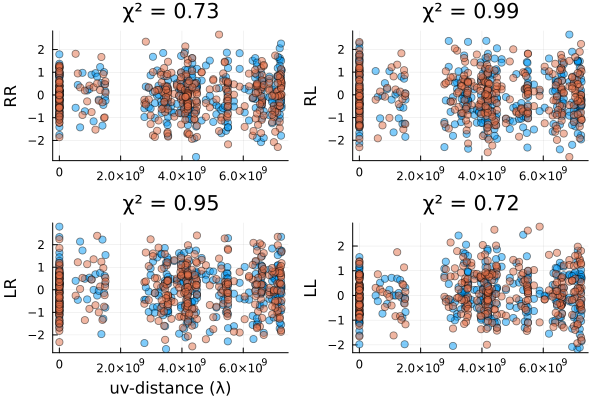

In [21]:
using Plots
residual(model(xopt, metadata), dvis)

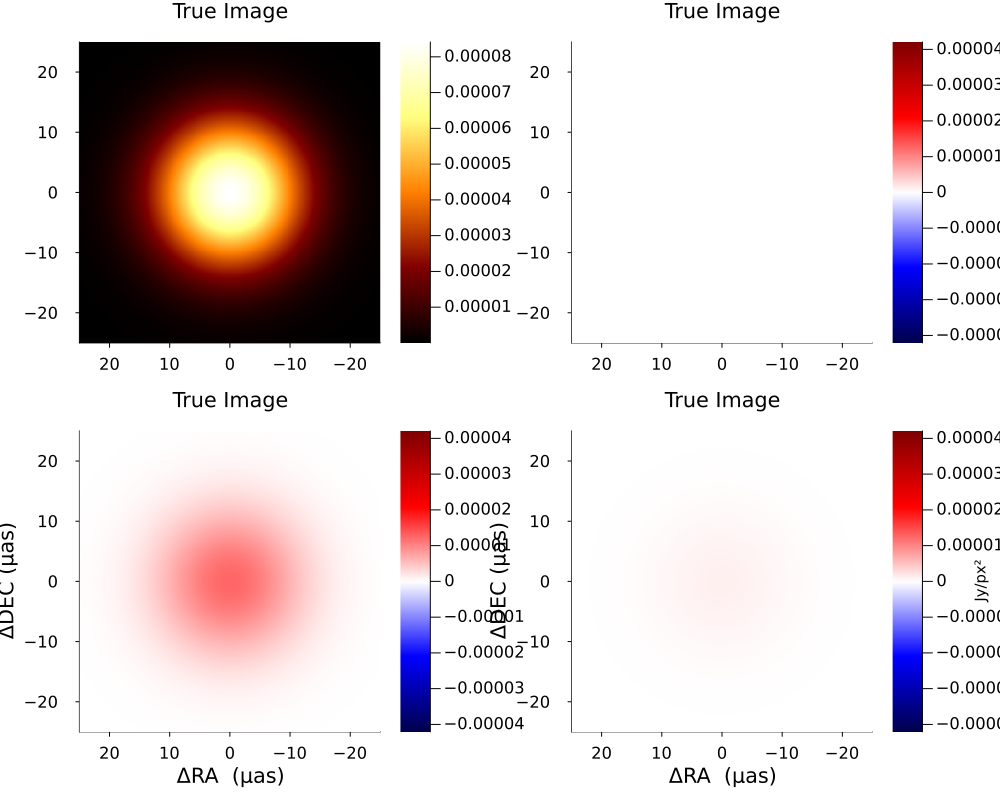

In [22]:
using AxisKeys
imgtrue = Comrade.load(joinpath(dirname(pathof(Comrade)), "..", "examples", "PolarizedExamples/polarized_gaussian.fits"), StokesIntensityMap)
imgtruesub = imgtrue(Interval(-fovx/2, fovx/2), Interval(-fovy/2, fovy/2))
plot(imgtruesub, title="True Image", xlims=(-25.0,25.0), ylims=(-25.0,25.0))

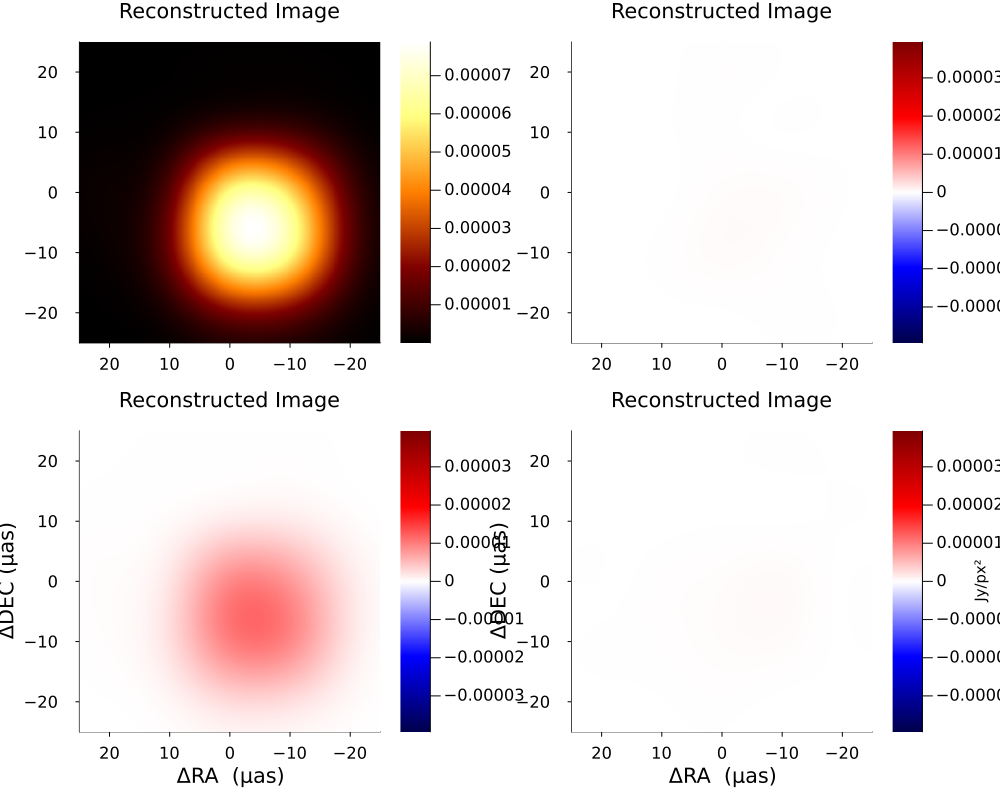

In [23]:
img = intensitymap!(copy(imgtruesub), model(xopt, metadata))
plot(img, title="Reconstructed Image", xlims=(-25.0,25.0), ylims=(-25.0,25.0))